# 2D representation of the data (SPRING plots) colored by annotation and gene of interest

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("../utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_utility_spring as srz

python version: 3.6.7


## Load  scRNAseq data

In [5]:
# load counts
adata = sc.read_h5ad('../data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [6]:
# overwrite obs with the most recent version
adata.obs = rz.load_df('../data/obs_info_27563x32_201025_14h44.npz')

## Load xy coordinates

In [7]:
# load a copy from spring directly, could be placed to adata.obs eventually
xy = pd.read_csv('../data/from_spring_all_Cd45pos_cells/coordinates.txt',header=None,index_col=0)
xy.head()

1           2
0                         
0   218.384705 -566.210362
1  1347.487578 -666.992489
2   990.861778  728.578157
3   -54.051913  193.164429
4  -329.868543  425.918932

In [8]:
!ls -lht ../data/from_spring_all_Cd45pos_cells/

total 15504
-rwxr-xr-x  1 rapolaszilionis  staff   6.4M Oct 25 14:44 categorical_coloring_data.json
-rwxr-xr-x  1 rapolaszilionis  staff   1.0M Oct 25 13:28 coordinates.txt
-rwxr-xr-x  1 rapolaszilionis  staff   196K Oct 25 13:28 cell_filter.npy


## Load cluster color dictionary
When making a spring plot, a file called "categorical_coloring_data.json" is generated. This file contains categorical coloring data (lists of labels, e.g. "condition") as well as colors used by the interactive spring explorer.

In [9]:
cg = srz.read_cell_groupings('../data/from_spring_all_Cd45pos_cells/categorical_coloring_data.json')
cg.keys()

dict_keys(['*population', 'Major cell type', 'closest_Immgen', 'closest_Immgen_simplified', 'closest_Zilionis2019_mouse_minor', 'condition', 'library', 'mouse', 'sp_cl_all_cells_clean_iter3_100', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score'])

In [10]:
cg['*population'].keys()

dict_keys(['label_colors', 'label_list'])

In [11]:
# drop the label lists, leave a dictionary of dictionaries of colors
cdd = {key:value['label_colors'] for key,value in cg.items()}
cdd

{'*population': {'B cells': '#4666B0',
  'Basophils': '#4c2e4d',
  'DC1': '#ff0000',
  'DC2': '#ff9900',
  'DC3': '#990000',
  'ILC': '#DB4677',
  'Mac1': '#ff3399',
  'Mac2': '#66ffff',
  'Mac3': '#9966ff',
  'Mac4': '#33cccc',
  'Mono1': '#e1e74b',
  'Mono2': '#6d700f',
  'Mono3': '#0099ff',
  'MonoDC': '#00cc00',
  'N1': '#0a5e75',
  'N2': '#66ffcc',
  'N3': '#008055',
  'N4': '#12a9d3',
  'N5': '#666699',
  'N6': '#EE2C7C',
  'NK cells': '#1F6935',
  'Plasma cells': '#ac0000',
  'T_Cd4': '#3275B5',
  'T_Cd8_Ccr7hi': '#60B9E9',
  'T_Cd8_Cxcr3hi': '#449688',
  'Tgd': '#DF7D44',
  'Treg': '#BC4024',
  'pDC': '#a094ff'},
 'Major cell type': {'B cells': '#4666b0',
  'Basophils': '#4c2e4d',
  'Dendritic cells': '#a094ff',
  'ILC': '#67bd45',
  'Monocytes/Macrophages': '#f8991d',
  'NK cells': '#1f6935',
  'Neutrophils': '#30c4ed',
  'T cells': '#67bd45'},
 'closest_Immgen': {'B1a_PC': '#faf000',
  'B1a_Sp': '#49ffad',
  'B1b_PC': '#25ffd0',
  'BA_Bl': '#adff49',
  'BA_Sp': '#d7ff1f',
  '

## Normalize total counts to 10k

In [12]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Function for coloring by gene expression values

In [13]:
def spring_like(
        genename,
        expression,
        x,y,
        box = [0,0,1,1],
        s = 5,
        pctilemax = 99.5,
        vmax=None,
        w = 3,
        h = 3,
        comment = '',
        pad = 0,
        ftype = 'pdf',
        dpi = 1200.,
        show_cbar=False,
        save=True,
        lims = [],
        show=True,
        outputdir='outputs/spring_like/'
        ):
    
    """Plot SPRING like gene expression.
    expression - vector with expression values
    x,y - coordinates, same shape as expression
    box - select how to crop the figures [x0,y0,x1,y1], where no cropping is [0,1,0,1]
    lims - is specified, will ignore "box", and use absolute x,y limit values, e.g. lims = [-2000,1000,-100,1500]
    vmax - value to saturate at, will overwrite the pctilemax argument
    """
    
    
    order = np.argsort(expression)
    expression = expression[order]
    
    # get selected percentile within the selected cells only
    if vmax is None:
        vmax = np.percentile(expression,pctilemax)
        
    else:
        pctilemax=0
    print(vmax)
    vmin = 0
    
    if vmin==vmax:
        expression = '#00ff00'
    
    x = x[order]
    y = y[order]
    
    a,fig,gs=rz.startfig(w,h,frameon=False)
    
    a.set_xticks([])
    a.set_yticks([])
    
    scatter = a.scatter(x,y,lw=0,s=s,c=expression,cmap=rz.custom_colormap(['#000000','#00ff00']),vmax=vmax,vmin=vmin)
    
    # adjust the limits of the plot
    # get current limits
    xlim0 = a.get_xlim()[0]
    xlim1 = a.get_xlim()[1]
    ylim0 = a.get_ylim()[0]
    ylim1 = a.get_ylim()[1]
    
    # get differences:
    dx = xlim1-xlim0
    dy = ylim1-ylim0
    
    # apply the cropping:
    xmin = xlim0+box[0]*dx
    xmax = xlim1-(1-box[2])*dx
    
    ymin = ylim0+box[1]*dy
    ymax = ylim1-(1-box[3])*dy
    
    if len(lims)==4:
        [xmin,ymin,xmax,ymax] = lims
    a.set_xlim(xmin,xmax)
    a.set_ylim(ymin,ymax)
    
    if show_cbar:
        cbar = plt.colorbar(scatter,orientation='horizontal')
        cbar.outline.set_visible(False)
        cbar.set_ticks([0,vmax])
        cbar.ax.set_xticklabels(['0th','>%0.1fth'%pctilemax])
    
    gs.tight_layout(fig,pad=pad)
    
    
    if save:
        plt.savefig(outputdir+'%s_scatter_%s_%.2f_pctile.%s'%(genename,comment,pctilemax,ftype),dpi=dpi)
    
    if show:
        plt.show()
    else:
        plt.close()

## SPRING plot of all cells

### Main figure

In [14]:
# boolean mask: not all cells in adata made it to the plot
# after cleanup (doublet removal, etc.)

colorby = 'Major cell type'
cmask = (~adata.obs[colorby].isna()).values
x = xy.iloc[:,0].values
y = -xy.iloc[:,1].values #flipped for some reason...
colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask]]

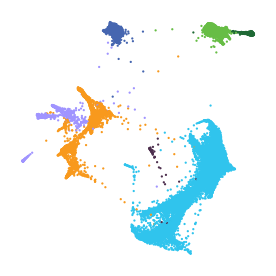

In [15]:
a,fig,gs = rz.startfig(10,10,frameon=False)
a.scatter(x,y,color=colors,lw=0,s=5)

a.set_xticks([])
a.set_yticks([])

gs.tight_layout(fig)

plt.savefig('outputs/fig2spring.png',dpi=600)
plt.savefig('outputs/fig2spring.pdf')
plt.show()

### Supplementary Figure

In [16]:
# boolean mask: not all cells in adata made it to the plot
# after cleanup (doublet removal, etc.)

colorby = 'condition'
cmask = (~adata.obs['*population'].isna()).values
x = xy.iloc[:,0].values
y = -xy.iloc[:,1].values #flipped for some reason...
colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask]]

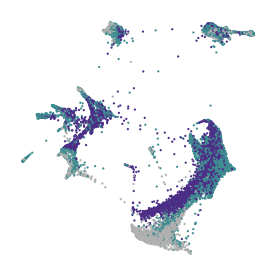

In [17]:
#randomize dot order:
np.random.seed(0)
rndorder = np.random.permutation(len(x))

a,fig,gs = rz.startfig(10,10,frameon=False)
a.scatter(x[rndorder],y[rndorder],color=np.array(colors)[rndorder],
          lw=0,s=5)

a.set_xticks([])
a.set_yticks([])

gs.tight_layout(fig)

plt.savefig('outputs/figS2spring_condition_rnd.png',dpi=600)
plt.savefig('outputs/figS2spring_condition_rnd.pdf')
plt.show()

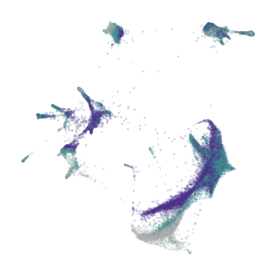

In [18]:
#randomize dot order + transparency:

a,fig,gs = rz.startfig(10,10,frameon=False)
a.scatter(x[rndorder],y[rndorder],color=np.array(colors)[rndorder],
          alpha=0.2,lw=0,s=5)

a.set_xticks([])
a.set_yticks([])

gs.tight_layout(fig)

plt.savefig('outputs/figS2spring_condition_rnd_transp.png',dpi=600)
plt.savefig('outputs/figS2spring_condition_rnd_transp.pdf')
plt.show()

### Expression of selected genes in all cells

In [19]:
genes = ['Ifng','Il12b']
ftypes = ['png','pdf']

19.43401560592908


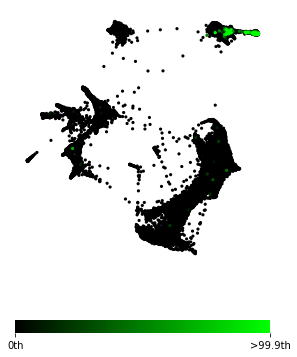

19.43401560592908
7.260516015055142


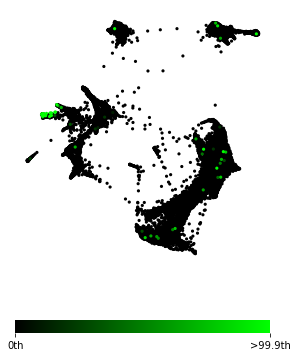

7.260516015055142


In [20]:
for gene in genes:
    
    gmask = adata.var_names == gene
    expression = adata.X[cmask][:,gmask].toarray().T[0]
    
    show=True
    for ftype in ftypes:
        spring_like(
                gene,
                expression,
                x,y,
                box = [0,0,1,1],
                s = 10,
                pctilemax = 99.9,
                vmax=None,
                w = 10,
                h = 13,
                comment = '',
                pad = 0,
                ftype = ftype,
                dpi = 1200.,
                show_cbar=True,
                lims = [],
                save=True,
                show=show,
                outputdir='outputs/'
                )
        show=False

## Mono/mac figures

### All conditions

In [21]:
colorby = '*population'
pick = ['Mac1', 'Mac2', 'Mac3', 'Mac4', 'Mono1', 'Mono2', 'Mono3', 'MonoDC']
cmask1 = adata.obs[colorby].isin(pick).values

x1 = x[cmask1[cmask]]
y1 = y[cmask1[cmask]]
colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1]]

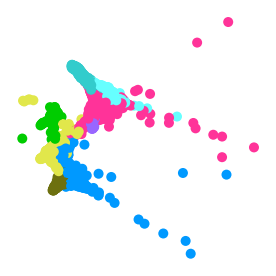

In [22]:
a,fig,gs = rz.startfig(10,10,frameon=False)
a.scatter(x1,y1,color=colors,lw=0,s=100)

a.set_xticks([])
a.set_yticks([])

xlims = a.get_xlim()
ylims = a.get_ylim()

gs.tight_layout(fig)

plt.savefig('outputs/fig2monomac/fig2momac_all.png',dpi=600)
plt.savefig('outputs/fig2monomac/fig2momac_all.pdf')
plt.show()

### Same plot but for each condition separately

CSF1Ri


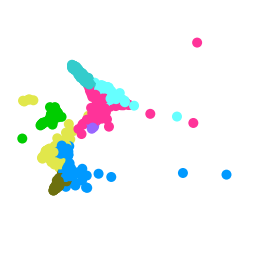

Vehicle


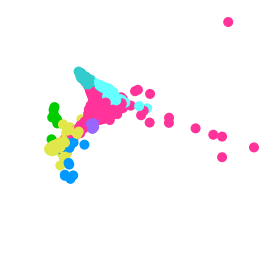

Healthy


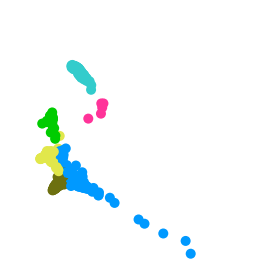

In [23]:
for cond in adata.obs.dropna()['condition'].unique():
    
    print(cond)
    cmask2 = adata.obs['condition'] == cond
    cmask2 = cmask2.values
    
    x1 = x[(cmask1&cmask2)[cmask]]
    y1 = y[(cmask1&cmask2)[cmask]]
    
    colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1&cmask2]]
    
    # plot
    a,fig,gs = rz.startfig(10,10,frameon=False)
    a.scatter(x1,y1,color=colors,lw=0,s=100)
    
    a.set_xticks([])
    a.set_yticks([])
    
    # prevent plot for being recentered relatively to the "all conditions" one
    a.set_xlim(xlims[0],xlims[1])
    a.set_ylim(ylims[0],ylims[1])
    
    gs.tight_layout(fig)
    
    plt.savefig('outputs/fig2monomac/fig2momac_%s.png'%cond,dpi=600)
    plt.savefig('outputs/fig2monomac/fig2momac_%s.pdf'%cond)
    plt.show()
    

### Color Mono/Mac plots by selected gene expression

In [24]:
# genes to plot
genes = ['Il12b','Cd80','Tlr4','Nos2','Cd163','Arg1',
        'Mrc1','Trem2']
pctilemax = 99.9

In [25]:
# First, I want to find the value to saturate the color at.
# I chose to saturated at the x-th percentile across all CD45 cells including all conditions

pctiledict = {}

for gene in genes:
    gmask = adata.var_names == gene
    expression = adata.X[cmask][:,gmask].toarray().T[0]
    pctiledict[gene] = np.percentile(expression,pctilemax)

CSF1Ri Il12b
7.260516015055142


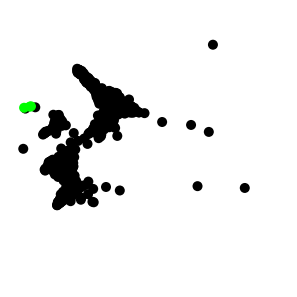

Vehicle Il12b
7.260516015055142


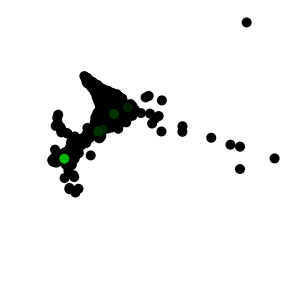

Healthy Il12b
7.260516015055142


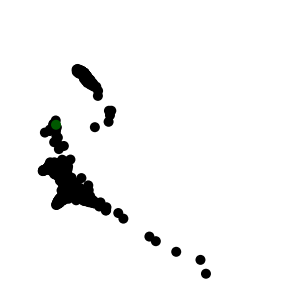

CSF1Ri Cd80
29.772390457154298


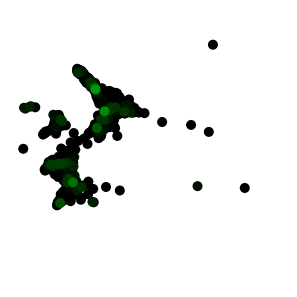

Vehicle Cd80
29.772390457154298


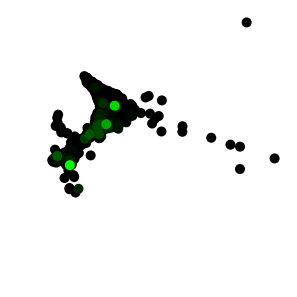

Healthy Cd80
29.772390457154298


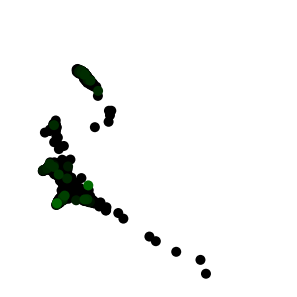

CSF1Ri Tlr4
33.620085685731


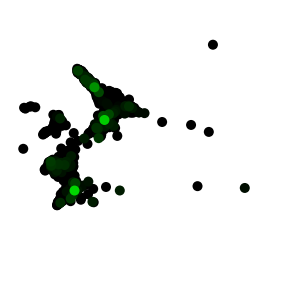

Vehicle Tlr4
33.620085685731


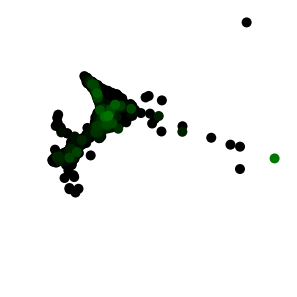

Healthy Tlr4
33.620085685731


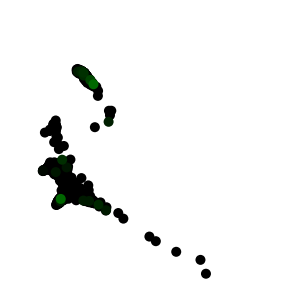

CSF1Ri Nos2
8.436827915191817


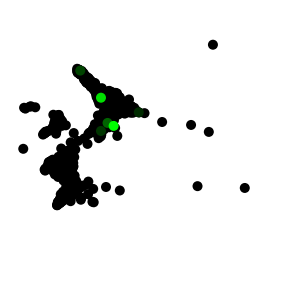

Vehicle Nos2
8.436827915191817


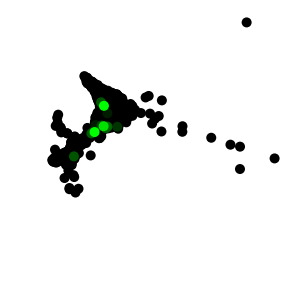

Healthy Nos2
8.436827915191817


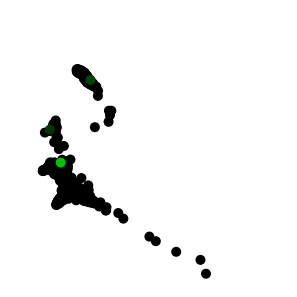

CSF1Ri Cd163
11.063361532212378


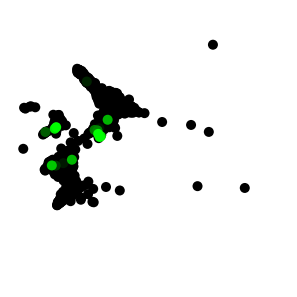

Vehicle Cd163
11.063361532212378


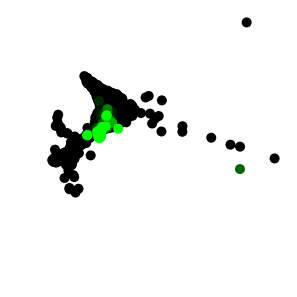

Healthy Cd163
11.063361532212378


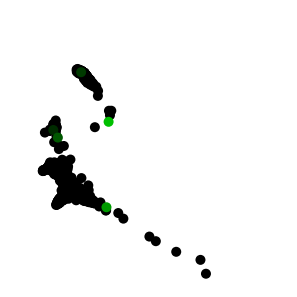

CSF1Ri Arg1
139.3664223022475


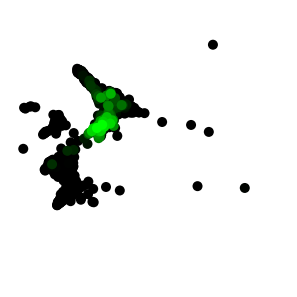

Vehicle Arg1
139.3664223022475


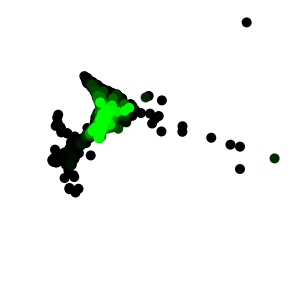

Healthy Arg1
139.3664223022475


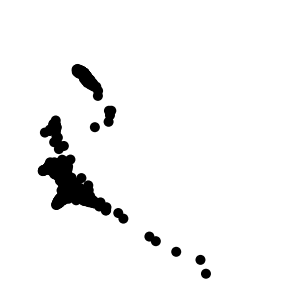

CSF1Ri Mrc1
56.78383413696762


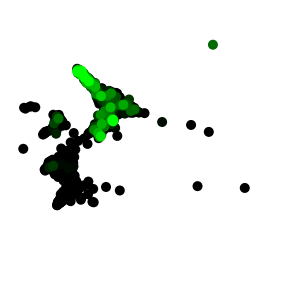

Vehicle Mrc1
56.78383413696762


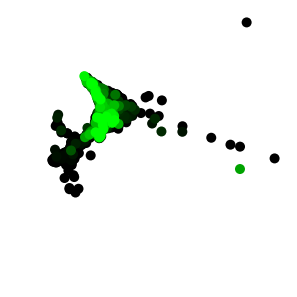

Healthy Mrc1
56.78383413696762


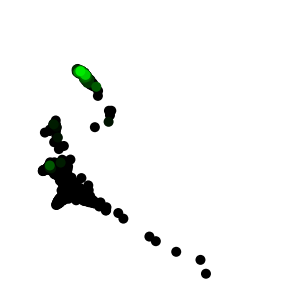

CSF1Ri Trem2
10.58861270713821


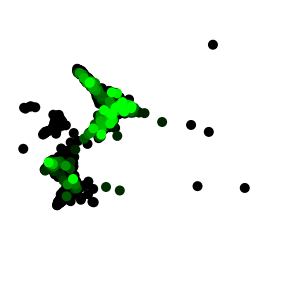

Vehicle Trem2
10.58861270713821


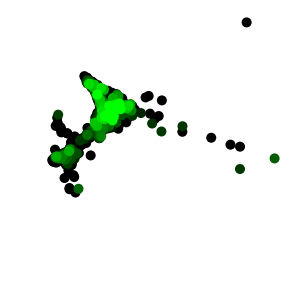

Healthy Trem2
10.58861270713821


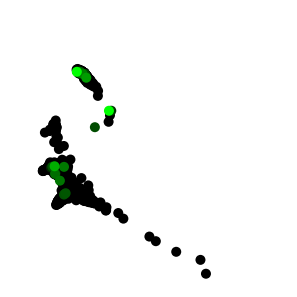

In [26]:
for gene in genes:
    for cond in adata.obs.dropna()['condition'].unique():
        
        print(cond,gene)
        cmask2 = adata.obs['condition'] == cond
        cmask2 = cmask2.values
        
        x1 = x[(cmask1&cmask2)[cmask]]
        y1 = y[(cmask1&cmask2)[cmask]]
        
        gmask = adata.var_names == gene
        expression = adata.X[cmask1&cmask2][:,gmask].toarray().T[0]
        
        spring_like(
                    gene,
                    expression,
                    x1,y1,
                    box = [0,0,1,1],
                    s = 100,
                    vmax=pctiledict[gene],
                    w = 10,
                    h = 10,
                    comment = 'Fig3B_%s'%cond,
                    pad = 0,
                    ftype = 'png',
                    dpi = 600.,
                    show_cbar=False,
                    lims = [xlims[0],ylims[0],xlims[1],ylims[1]],
                    save=True,
                    show=True,
                    outputdir='outputs/fig2monomac/'
                    )
    

### Supplementary figure: more genes to color by

In [27]:
# genes to plot
genes = ['C1qb','Gpnmb','Saa3','Ear1',
        'Ccr2','Cd300e','S100a9','Cd7']

pctilemax = 99.9

C1qb
78.36892889404658


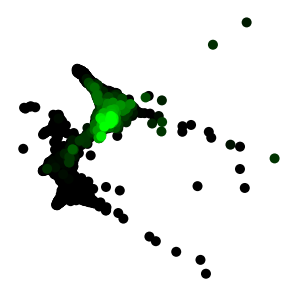

Gpnmb
216.85432405090816


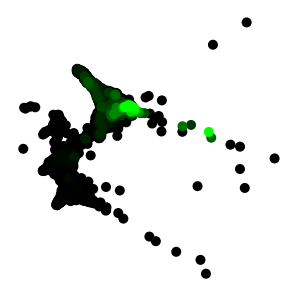

Saa3
536.567979431153


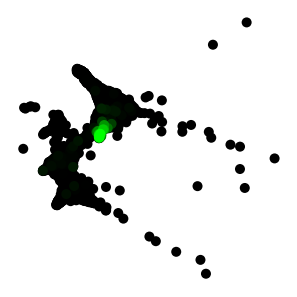

Ear1
30.703022439957433


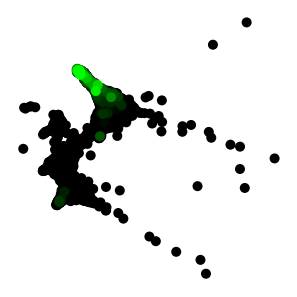

Ccr2
62.33903881836046


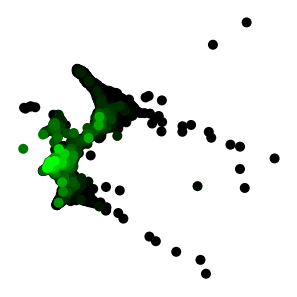

Cd300e
34.10458397674884


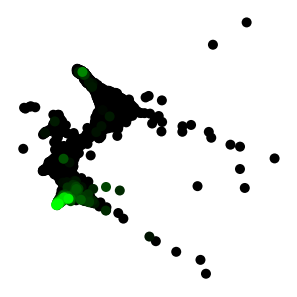

S100a9
350.76001904296874


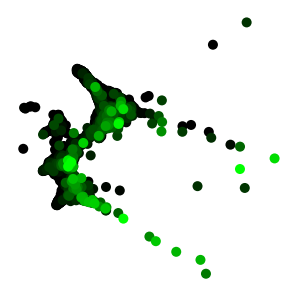

Cd7
23.919792972564803


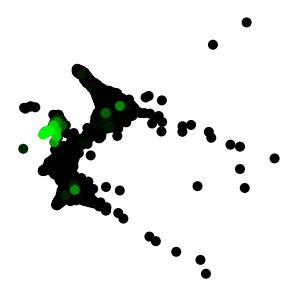

In [28]:
for gene in genes:
        
    print(gene)
    
    x1 = x[(cmask1)[cmask]]
    y1 = y[(cmask1)[cmask]]
    
    gmask = adata.var_names == gene
    expression = adata.X[cmask1][:,gmask].toarray().T[0]
    
    spring_like(
                gene,
                expression,
                x1,y1,
                box = [0,0,1,1],
                pctilemax=pctilemax,
                s = 100,
                w = 10,
                h = 10,
                comment = 'FigS2_',
                pad = 0,
                ftype = 'png',
                dpi = 600.,
                show_cbar=False,
                lims = [xlims[0],ylims[0],xlims[1],ylims[1]],
                save=True,
                show=True,
                outputdir='outputs/fig2monomac/'
                )


In [29]:
!open outputs/fig2monomac/

## DCs

### All conditions

In [30]:
colorby = '*population'
pick = ['DC1', 'DC2', 'DC3']
cmask1 = adata.obs[colorby].isin(pick).values

x1 = x[cmask1[cmask]]
y1 = y[cmask1[cmask]]
colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1]]

In [31]:
!mkdir -p outputs/fig5dcs

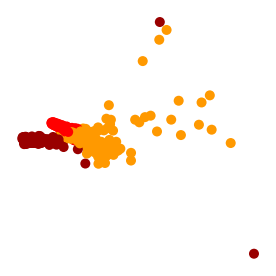

In [32]:
a,fig,gs = rz.startfig(10,10,frameon=False)
a.scatter(x1,y1,color=colors,lw=0,s=100)

a.set_xticks([])
a.set_yticks([])

xlims = a.get_xlim()
ylims = a.get_ylim()

gs.tight_layout(fig)

plt.savefig('outputs/fig5dcs/fig2dc_all.png',dpi=600)
plt.savefig('outputs/fig5dcs/fig2dc_all.pdf')
plt.show()

### Same plot but for each condition separately

CSF1Ri


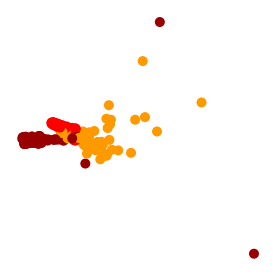

Vehicle


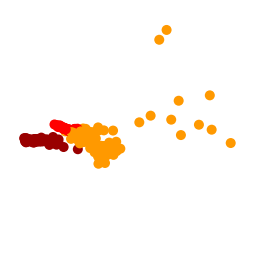

Healthy


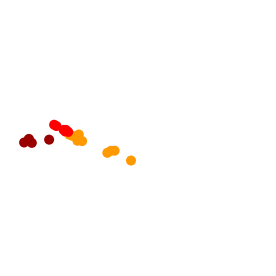

In [33]:
for cond in adata.obs.dropna()['condition'].unique():
    
    print(cond)
    cmask2 = adata.obs['condition'] == cond
    cmask2 = cmask2.values
    
    x1 = x[(cmask1&cmask2)[cmask]]
    y1 = y[(cmask1&cmask2)[cmask]]
    
    colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1&cmask2]]
    
    # plot
    a,fig,gs = rz.startfig(10,10,frameon=False)
    a.scatter(x1,y1,color=colors,lw=0,s=100)
    
    a.set_xticks([])
    a.set_yticks([])
    
    # prevent plot for being recentered relatively to the "all conditions" one
    a.set_xlim(xlims[0],xlims[1])
    a.set_ylim(ylims[0],ylims[1])
    
    gs.tight_layout(fig)
    
    plt.savefig('outputs/fig5dcs/fig2dc_%s.png'%cond,dpi=600)
    plt.savefig('outputs/fig5dcs/fig2dc_%s.pdf'%cond)
    plt.show()
    

### Plot of Il12b expression in DCs

In [34]:
# genes to plot
genes = ['Il12b']
pctilemax = 99.9

In [35]:
# First, I want to find the value to saturate the color at.
# I chose to saturated at the x-th percentile across all CD45 cells including all conditions

pctiledict = {}

for gene in genes:
    gmask = adata.var_names == gene
    expression = adata.X[cmask][:,gmask].toarray().T[0]
    pctiledict[gene] = np.percentile(expression,pctilemax)

CSF1Ri Il12b
7.260516015055142


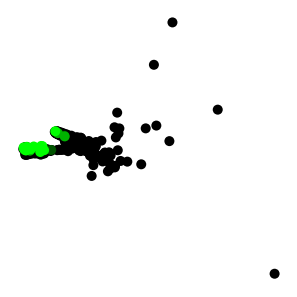

Vehicle Il12b
7.260516015055142


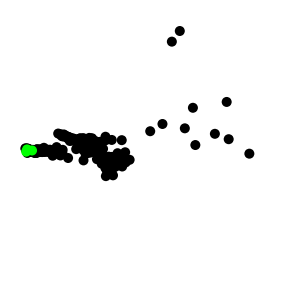

Healthy Il12b
7.260516015055142


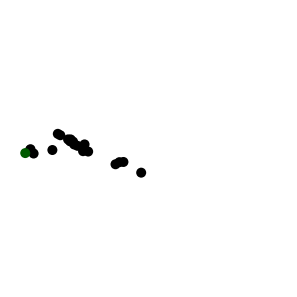

In [36]:
for gene in genes:
    for cond in adata.obs.dropna()['condition'].unique():
        
        print(cond,gene)
        cmask2 = adata.obs['condition'] == cond
        cmask2 = cmask2.values
        
        x1 = x[(cmask1&cmask2)[cmask]]
        y1 = y[(cmask1&cmask2)[cmask]]
        
        gmask = adata.var_names == gene
        expression = adata.X[cmask1&cmask2][:,gmask].toarray().T[0]
        
        spring_like(
                    gene,
                    expression,
                    x1,y1,
                    box = [0,0,1,1],
                    s = 100,
                    vmax=pctiledict[gene],
                    w = 10,
                    h = 10,
                    comment = 'Fig5C_%s'%cond,
                    pad = 0,
                    ftype = 'png',
                    dpi = 600.,
                    show_cbar=False,
                    lims = [xlims[0],ylims[0],xlims[1],ylims[1]],
                    save=True,
                    show=True,
                    outputdir='outputs/fig5dcs/'
                    )
    

## T cells

### All conditions

In [45]:
colorby = '*population'
pick = ['T_Cd8_Cxcr3hi','T_Cd8_Ccr7hi','T_Cd4','NK cells','Tgd','Treg','ILC']
cmask1 = adata.obs[colorby].isin(pick).values

x1 = x[cmask1[cmask]]
y1 = y[cmask1[cmask]]
colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1]]

In [46]:
!mkdir -p outputs/tnkcells

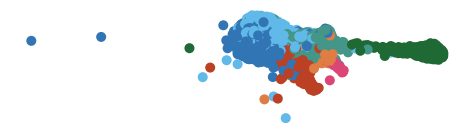

In [47]:
a,fig,gs = rz.startfig(17,5,frameon=False)
a.scatter(x1,y1,color=colors,lw=0,s=100)

a.set_xticks([])
a.set_yticks([])

xlims = a.get_xlim()
ylims = a.get_ylim()

gs.tight_layout(fig)

plt.savefig('outputs/tnkcells/all_condition_tnk.png',dpi=600)
plt.savefig('outputs/tnkcells/all_condition_tnk.pdf')
plt.show()

### Expression of selected genes in T and NK cells (no split by conditions)

In [49]:
###
prev = ['Cd4','Cd8a','Foxp3','Nkg7',
        'Ccr7','Tcf7','Lag3','Pdcd1']

now = [
    "Plac8",
"Cd8b1",
"Cd8a",
"St8sia6",
"Ndrg3",
"Satb1",
"Cntnap1",
"Myo6",
"Scml4",
"Il7r",
"Thy1",
"Cd4",
"Cd28",
"Trbc2",
"Bcl11b",
"Fam46c",
"Gas5",
"Rpl38",
"Rplp1",
"Rpl31",
"Rps6",
"Rpl21",
"Rps25",
"Rps4x",
"Gm16519",
"Rpsa",
"Rps15a",
"Rpl32",
"Rpl23a",
"Rpl12",
"Rpl17",
"Rpl13",
"Rps24",
"Rpl23",
"Rps7",
"Eef1b2",
"Rps28",
"Rps20",
"Rpl5",
"Rps5",
"Rpl36a",
"Rps3",
"Rps10",
"Rps19",
"Rplp0",
"Rps18",
"Rps8",
"Rps16",
"Dapl1",
"Fam241a",
"Igfbp4",
"Rps17",
"Trib2",
"Il6ra",
"Tcf7",
"AC160336.1",
"AC111046.1",
"Gm12840",
"Slmapos2",
"Plcg1",
"Crlf3",
"S1pr1",
"Socs3",
"Ms4a6b",
"Gramd3",
"Gm8369",
"Itga6",
"9330199G10Rik",
"Lef1",
"Dgka",
"Zfp281",
"Als2cl",
"Npc2",
"Rflnb",
"Pdk1",
"Nsg2",
"Actn1",
"Ccr7",
"Trdc",
"Tcrg-C2",
"Jaml",
"Dusp2",
"Ccl5",
"Cd7",
"Klrd1",
"Xcl1",
"Nkg7",
"Ly6c2",
"Ccl4",
"Anxa2",
"Itgb2",
"Efhd2",
"Klrc1",
"Chsy1",
"Ifng",
"Fcer1g",
"Klrk1",
"Eomes",
"Klrc2",
"Klra7",
"Plek",
"Gzma",
"Gzmb",
"Klrb1c",
"Klre1",
"Klrb1b",
"Tyrobp",
"Itgam",
"Cma1",
"Klra8",
"Irf8",
"Ncr1",
"Klri2",
"Klra4",
"Serpinb9b",
"Klrb1f",
"Serpinb9",
"Serpinb6b",
"Prf1",
"Ccl3",
"Ahnak",
"Id2",
"Serpina3g",
"Serinc3",
"Rab8b",
"Rgs1",
"Prr13",
"Il18r1",
"Hmgb2",
"Lgals1",
"Itgb1",
"Vim",
"S100a6",
"S100a10",
"AW112010",
"Il2rb",
"Cd48",
"Gimap4",
"Sla2",
"Psmb8",
"Hopx",
"Ybx3",
"Itga1",
"Gzmk",
"Lgals3",
"Chmp1b",
"AU020206",
"Cxcr3",
"Smco4",
"Ctla4",
"Smpdl3a",
"Nrp1",
"Itgae",
"Maf",
"Glrx",
"Trim59",
"Izumo1r",
"Ifi27l2a",
"Mki67",
"Tnfrsf4",
"Foxp3",
"Hif1a",
"Arl5a",
"Cdk6",
"Tspan13",
"Jun",
"Nfkbiz",
"Nr4a1",
"Il1rl1",
"Areg",
"Cxcl2",
"Ahcyl2",
"Hes1",
"Kit",
"Arg1",
"Slc7a8",
"Prnp",
"Pard3",
"Rnf128",
"Hs3st1",
"Calca",
"Fos",
"Egr1",
"Gadd45b",
"Junb",
"Cd81",
"Cdkn1a",
"Irs2",
"Gm42031",
"Ier2",
"Fgl2",
"Ctla2a",
"Crem",
"Dusp1",
"Srgn",
"Cish",
"Cebpb",
"Mdfic",
"Il2ra",
"Zfp36l1",
"Rgs2",
"Gata3",
"Itm2c",
"Tnfrsf18",
"Ccr6",
"Blk",
"Cd163l1",
"Il17re",
"Tnf",
"Sptssa",
"Aqp3",
"Lmo4",
"Ltb4r1",
"Ramp1",
"Tcrg-C1",
"Krt83",
"Tmem176a",
"Tmem176b",
"Igf1r",
"Rexo2",
"Serpinb1a",
"Smox",
"Tmem64",
"Icos",
"Ly6a",
"Rora",
"Capg",
"Bcl2a1b",
"S100a4",
"Cd82",
"Ikzf2",
"Odc1",
"Cxcr6",
"Socs2",
"Tcrg-C4",
"Tnfsf10"
]

genes = now + prev
genes = rz.oset(genes)

In [50]:
pctilemax = 99.9

Plac8
48.124071472168396


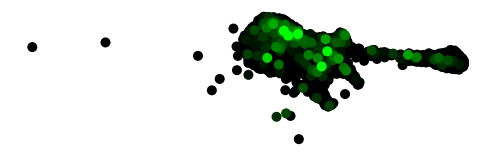

Cd8b1
56.579537811279984


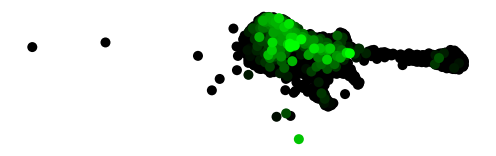

Cd8a
35.99132492065448


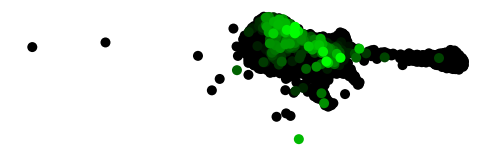

St8sia6
26.948645599365964


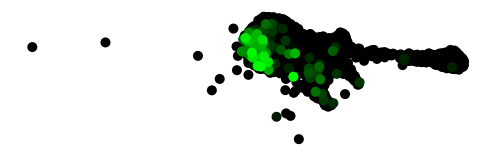

Ndrg3
21.805874267578282


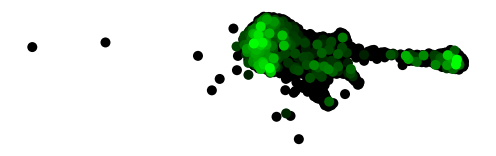

Satb1
66.59265966796903


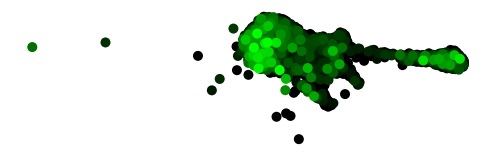

Cntnap1
26.381343200683823


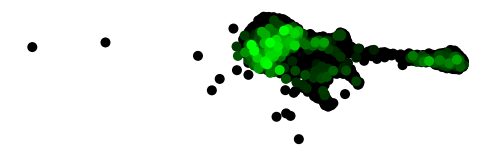

Myo6
56.9406112365725


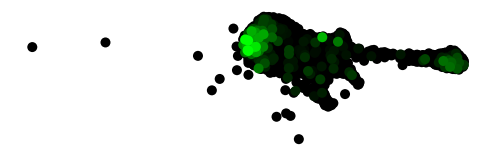

Scml4
62.521946777343814


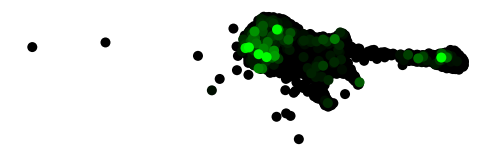

Il7r
66.87813409423859


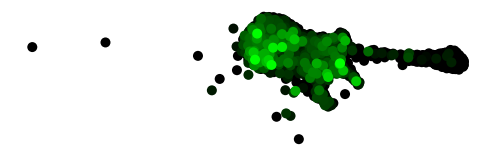

Thy1
84.24915484619206


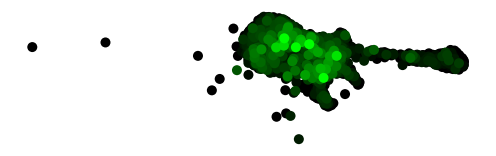

Cd4
48.89504724121212


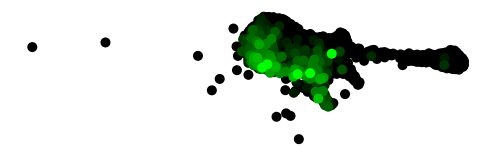

Cd28
57.20917590332124


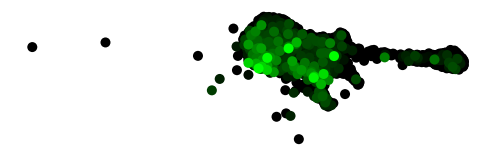

Trbc2
116.66399737548842


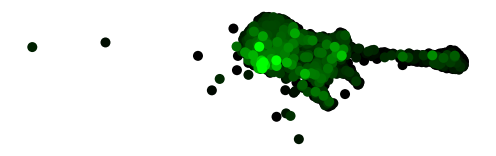

Bcl11b
77.88957037353624


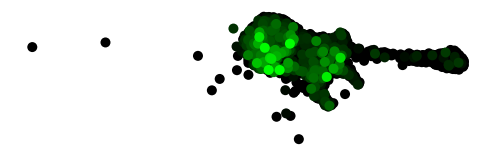

Fam46c
32.98314318847683


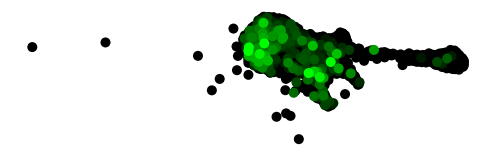

Gas5
99.94389312744264


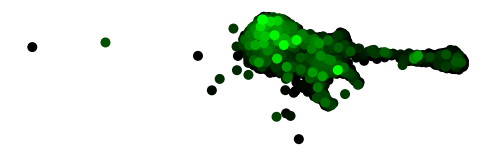

Rpl38
145.51146960449233


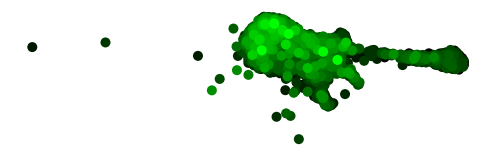

Rplp1
108.33951354980874


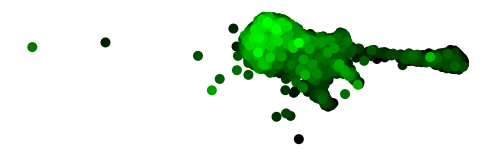

Rpl31
109.917462463379


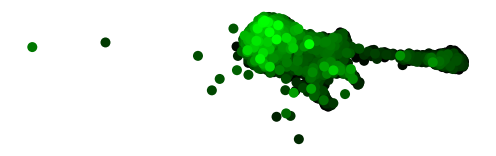

Rps6
174.4074133300782


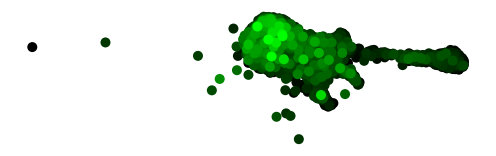

Rpl21
169.22295520019617


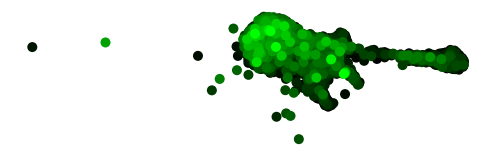

Rps25
129.82191082764058


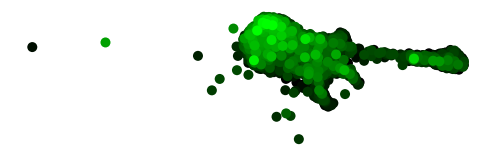

Rps4x
143.9155944824223


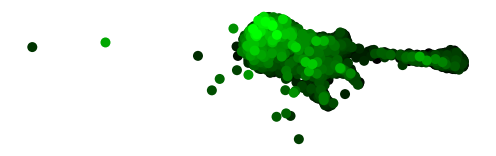

Gm16519
19.535120635986395


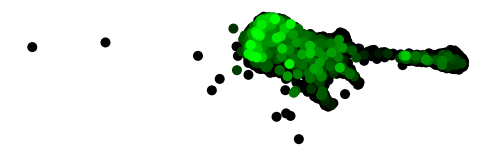

Rpsa
136.1498046875021


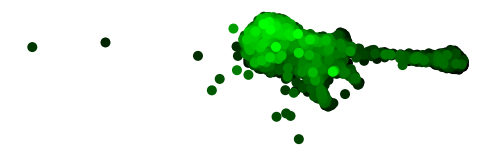

Rps15a
149.33481250000003


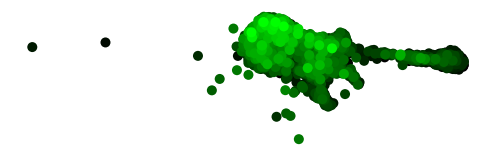

Rpl32
150.62729187011936


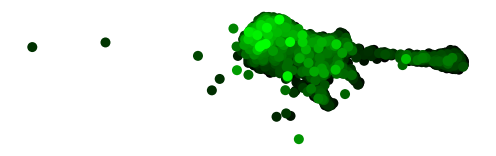

Rpl23a
149.9741347656258


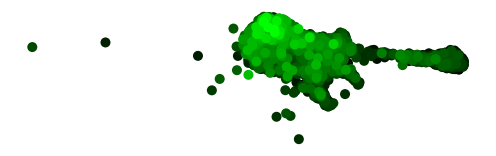

Rpl12
409.5245751953146


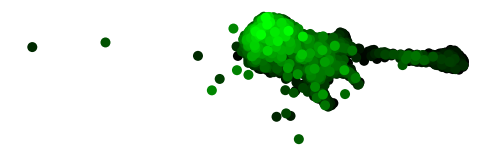

Rpl17
156.42556762695344


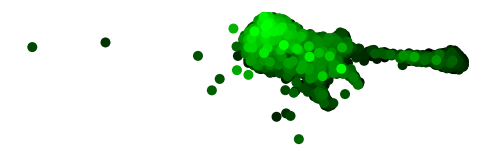

Rpl13
176.97560729980543


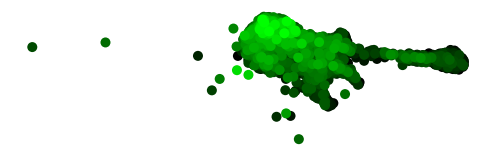

Rps24
309.3036928710949


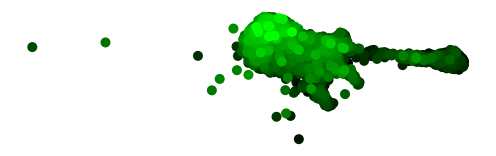

Rpl23
282.7507727050807


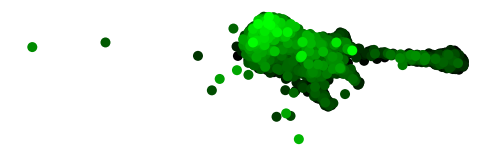

Rps7
85.66155285644534


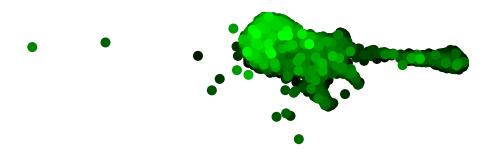

Eef1b2
126.77295080566446


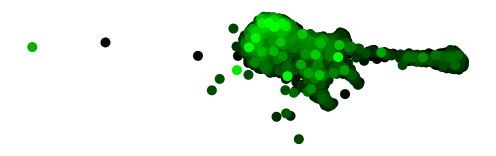

Rps28
225.5181826171913


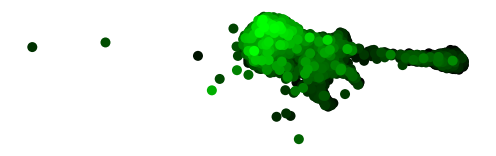

Rps20
124.19523474121094


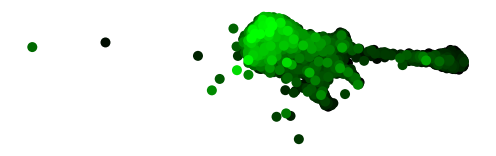

Rpl5
181.4572425537113


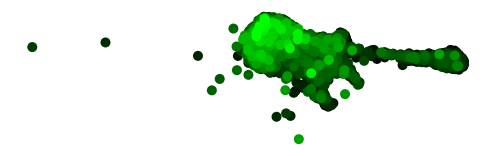

Rps5
150.56533422851888


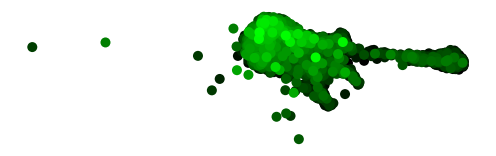

Rpl36a
73.54411151123053


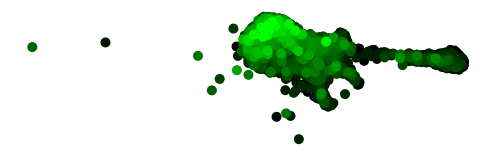

Rps3
201.51230957031484


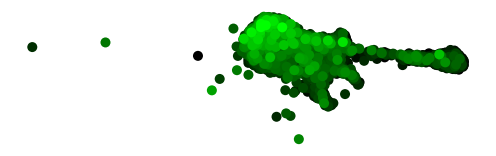

Rps10
108.08019433593846


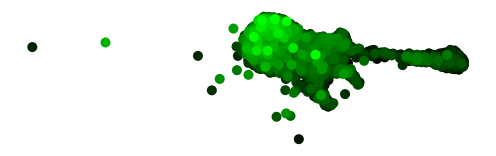

Rps19
176.83080004882888


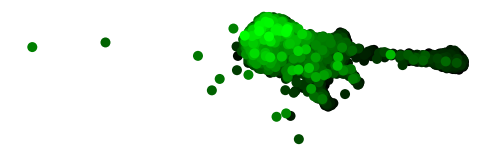

Rplp0
135.67425988769693


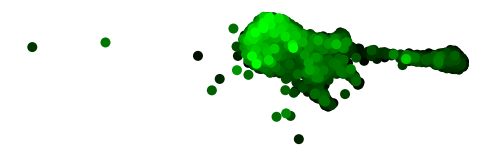

Rps18
70.84110333252009


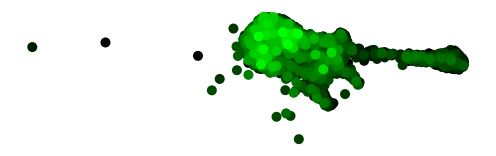

Rps8
138.55670886230473


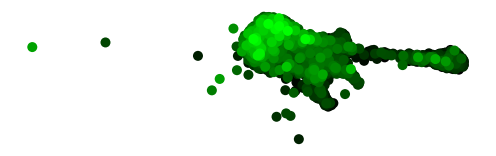

Rps16
213.74726794433607


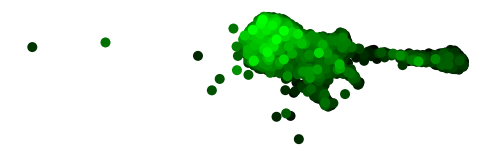

Dapl1
38.705444915771885


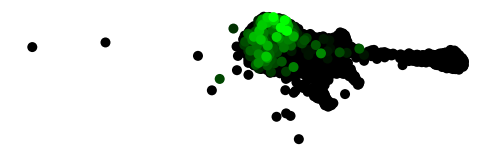

Fam241a
34.709712677004894


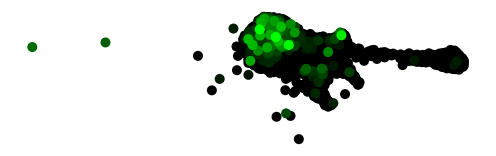

Igfbp4
88.04227441406331


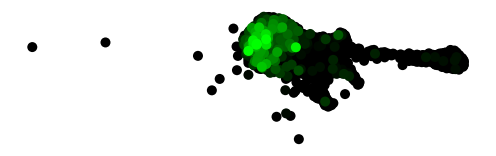

Rps17
105.55674310302787


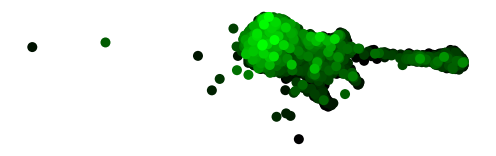

Trib2
35.57703585815489


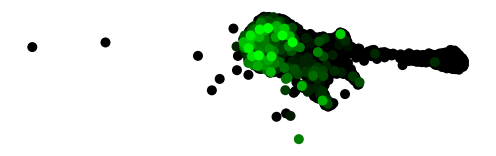

Il6ra
38.082747741699556


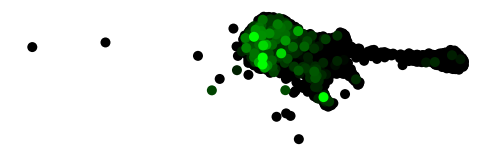

Tcf7
62.55352340698322


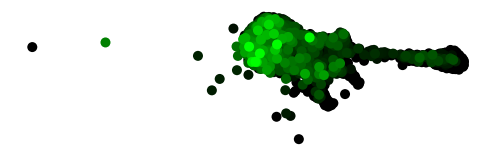

AC160336.1
178.2165091552769


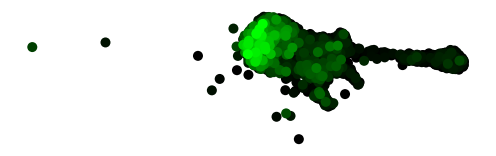

AC111046.1
66.42768585205079


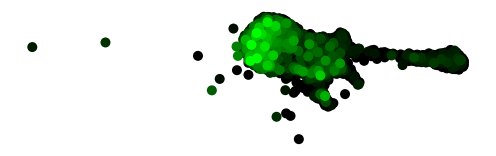

Gm12840
51.088849060059886


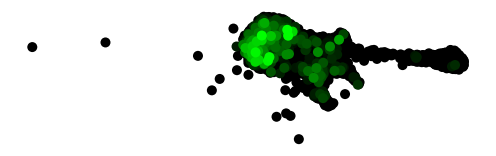

Slmapos2
27.943790939331183


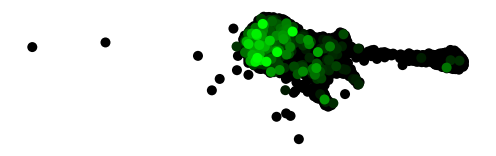

Plcg1
33.98982263183603


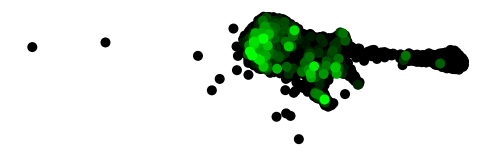

Crlf3
57.4701082153321


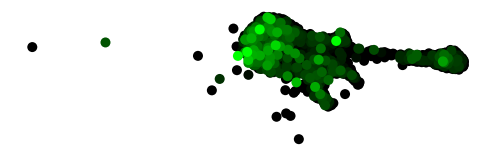

S1pr1
98.4194885253911


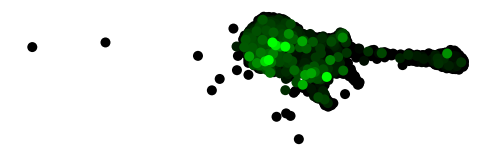

Socs3
44.638842102051846


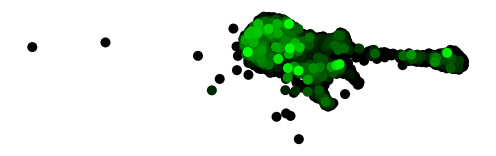

Ms4a6b
64.36026953125015


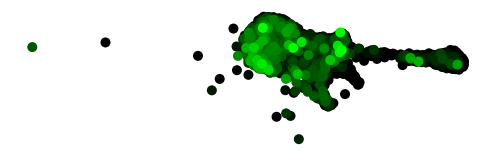

Gramd3
69.16414392089875


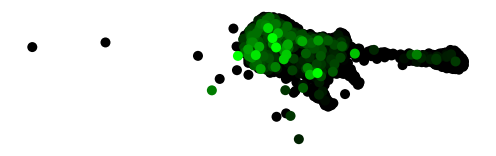

Gm8369
36.18051843261809


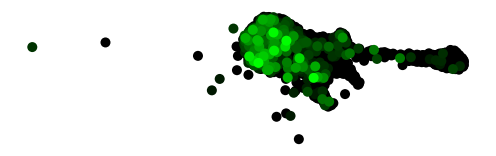

Itga6
47.20194989013876


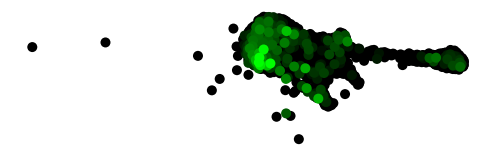

9330199G10Rik
22.828616165161147


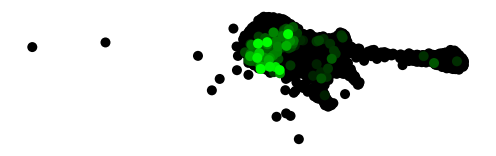

Lef1
92.24839648437764


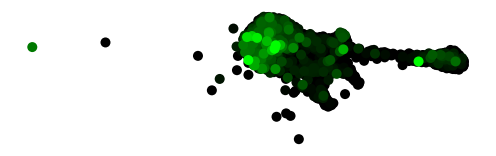

Dgka
50.79247311401402


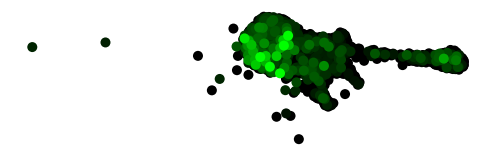

Zfp281
30.387178405762068


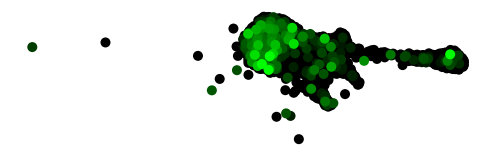

Als2cl
28.98059266662645


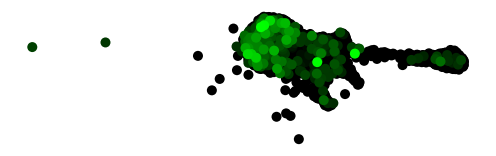

Npc2
48.99635342407233


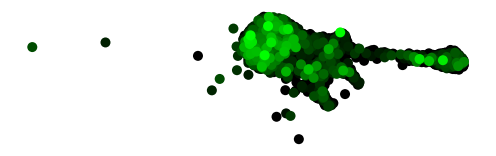

Rflnb
72.74086865234393


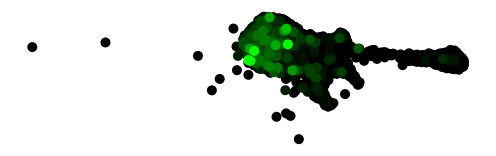

Pdk1
34.92886517334076


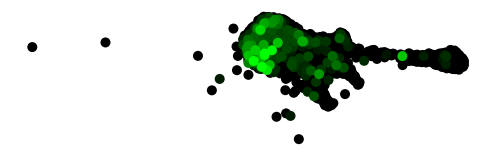

Nsg2
43.28139080810607


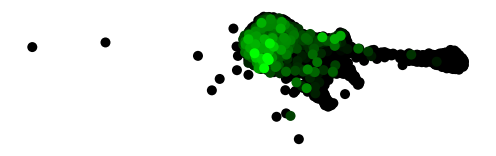

Actn1
65.59581542968823


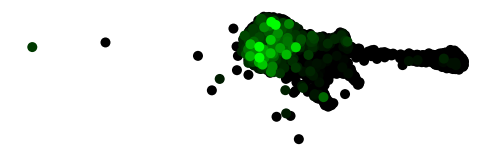

Ccr7
52.97006762695375


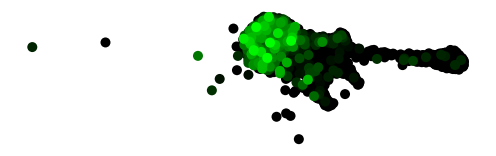

Trdc
52.159538269043395


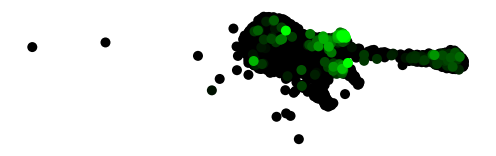

Tcrg-C2
31.15992973327722


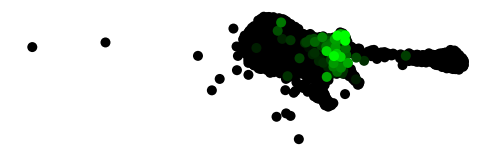

Jaml
34.24917343139663


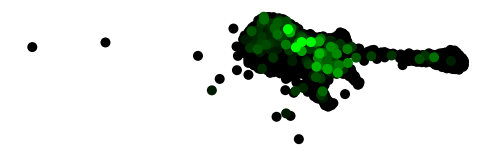

Dusp2
188.74594750976598


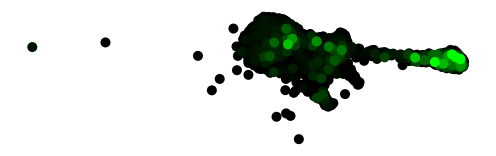

Ccl5
345.301393310547


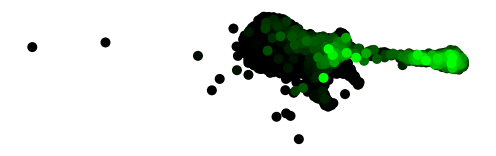

Cd7
40.31374459838878


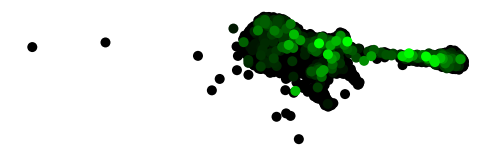

Klrd1
74.22389410400409


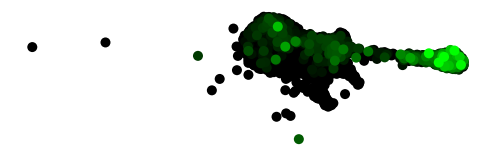

Xcl1
159.3189194335945


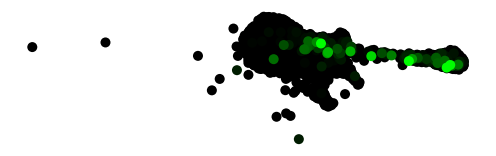

Nkg7
73.57693249511773


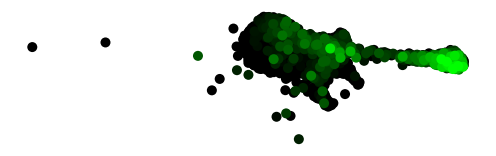

Ly6c2
29.49642863464379


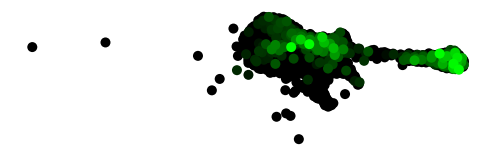

Ccl4
325.7028635253958


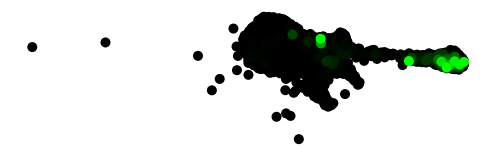

Anxa2
35.73127731323302


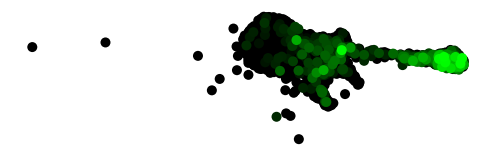

Itgb2
111.03063208008157


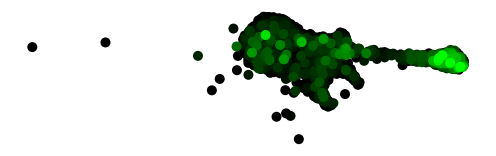

Efhd2
61.947464935303074


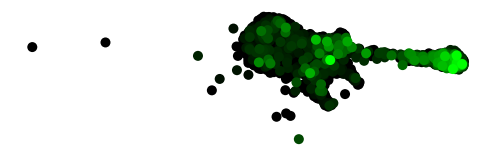

Klrc1
47.3007502136232


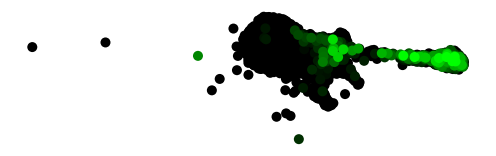

Chsy1
49.74296704101573


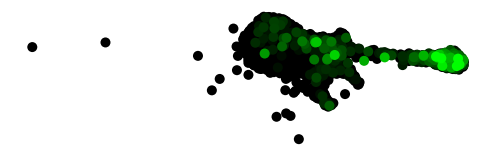

Ifng
53.526129516602914


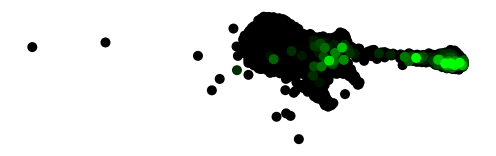

Fcer1g
79.66549298095745


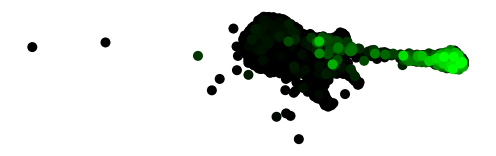

Klrk1
54.122388061523786


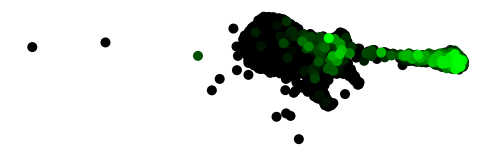

Eomes
54.09483129882963


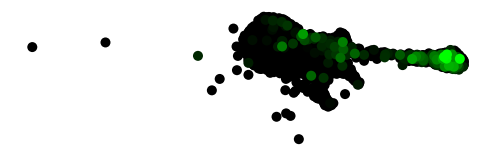

Klrc2
28.068996612549043


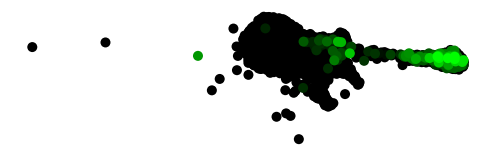

Klra7
50.969235351564016


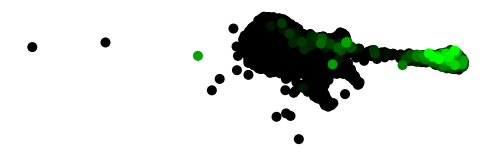

Plek
51.51904409790373


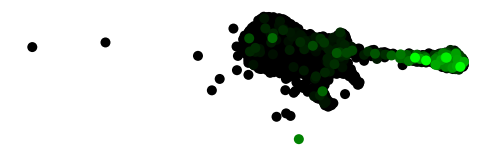

Gzma
328.81320556640793


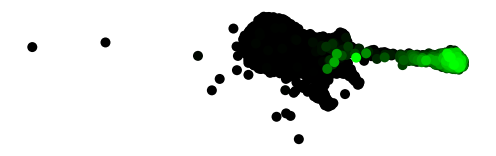

Gzmb
177.36576879882867


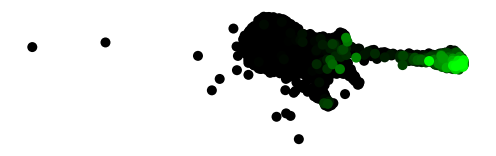

Klrb1c
66.2896140136749


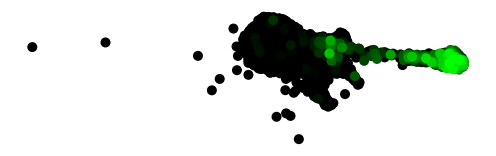

Klre1
59.395857055664216


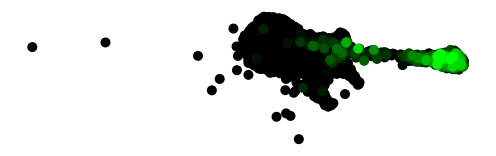

Klrb1b
60.84491180420069


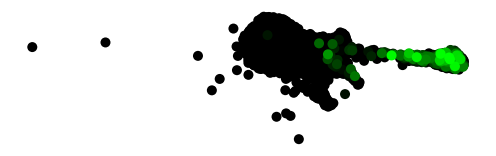

Tyrobp
55.121307861328376


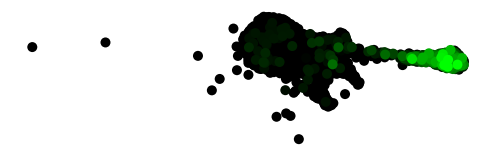

Itgam
39.66576751709044


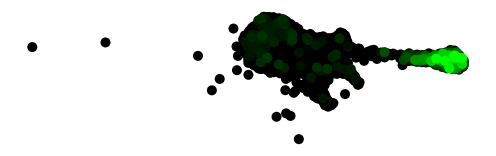

Cma1
53.87115219116316


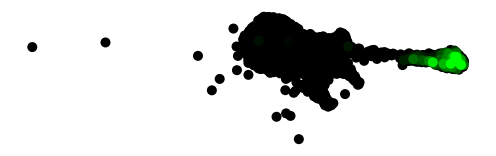

Klra8
39.299584350586834


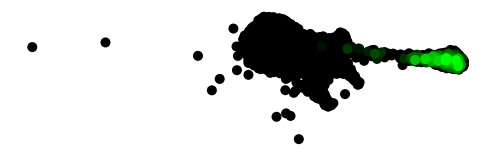

Irf8
69.29637091064455


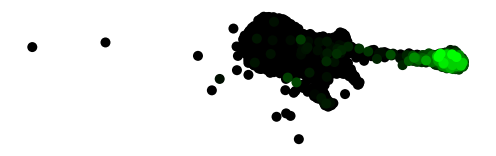

Ncr1
85.60110467529313


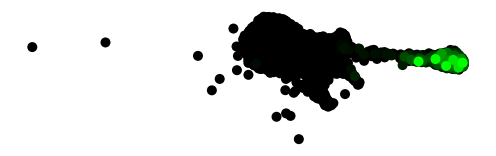

Klri2
40.02692227172891


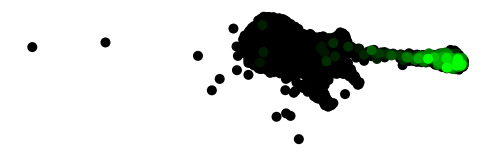

Klra4
74.88843292236356


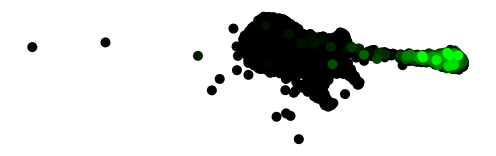

Serpinb9b
48.9952758178718


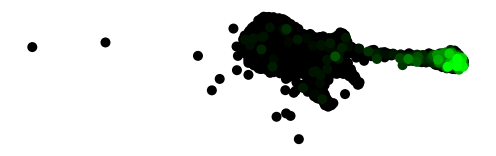

Klrb1f
40.219411865234804


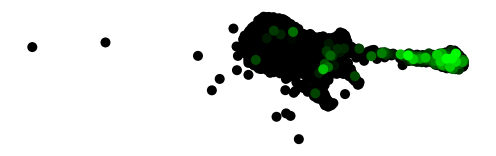

Serpinb9
43.82981805419937


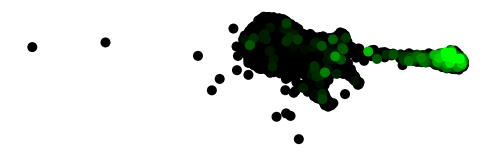

Serpinb6b
44.27958163452254


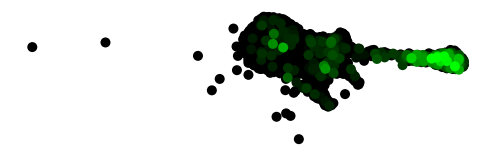

Prf1
118.20022003173908


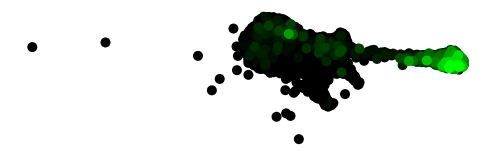

Ccl3
72.61445892333985


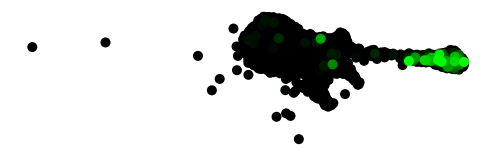

Ahnak
99.43147216797051


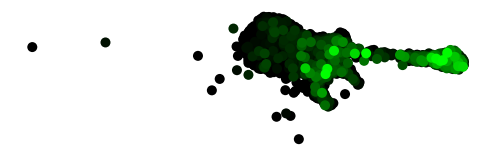

Id2
99.26794281005883


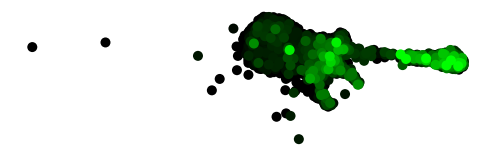

Serpina3g
26.60982273864793


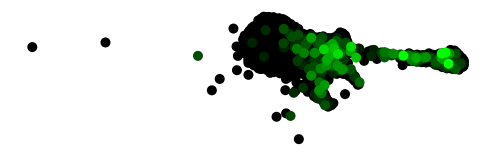

Serinc3
127.7238688964845


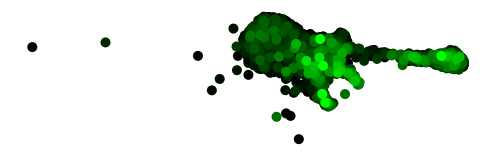

Rab8b
37.179147033691414


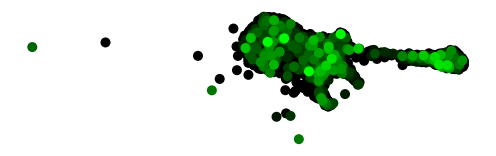

Rgs1
95.21124902343766


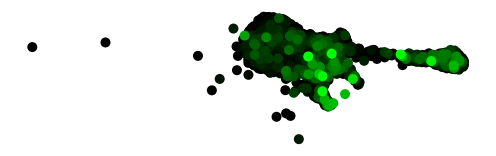

Prr13
57.928468566894914


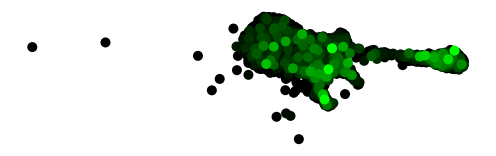

Il18r1
26.142791564941458


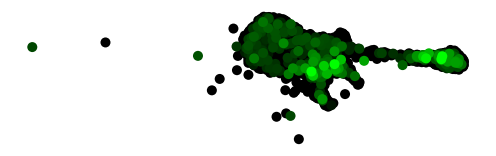

Hmgb2
73.56016064453267


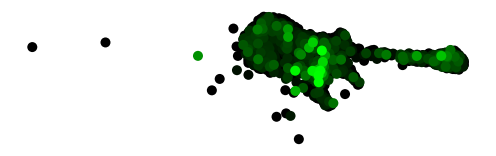

Lgals1
64.08367126464852


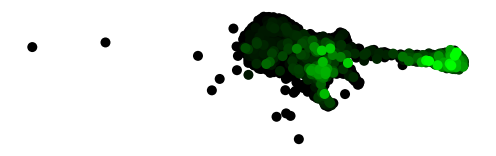

Itgb1
89.64704370117252


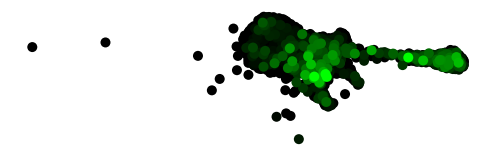

Vim
84.00226977539181


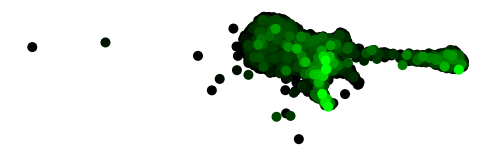

S100a6
127.71579443359815


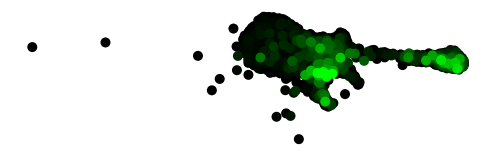

S100a10
51.66601300048843


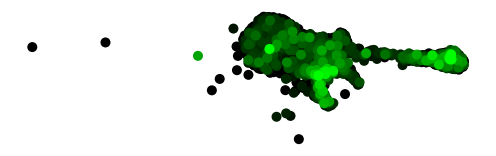

AW112010
112.85562768554838


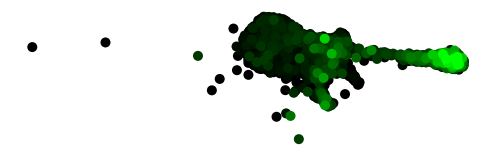

Il2rb
73.76683264160157


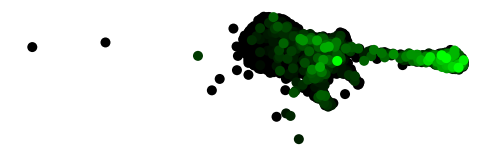

Cd48
45.49684146118178


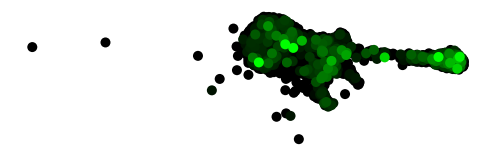

Gimap4
65.5019532470707


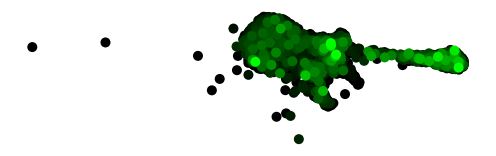

Sla2
24.174103973388767


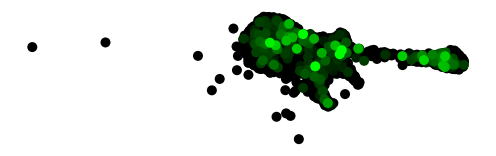

Psmb8
40.57508728027391


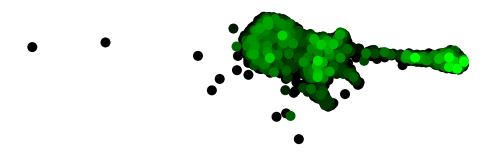

Hopx
21.111779373168975


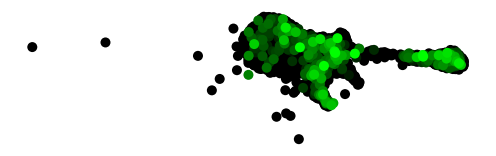

Ybx3
22.539670303344902


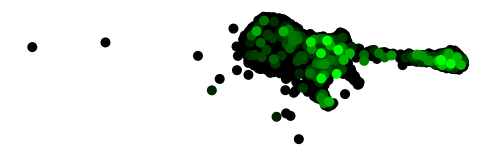

Itga1
17.873382369995387


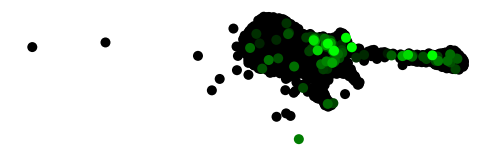

Gzmk
20.23113360595734


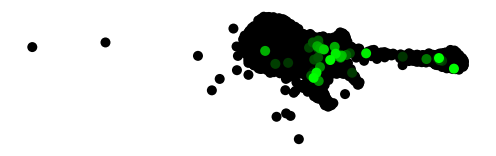

Lgals3
18.297038787841814


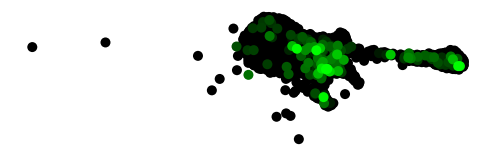

Chmp1b
38.78859930419929


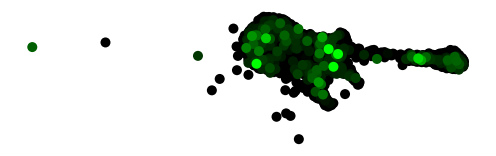

AU020206
26.085778167726268


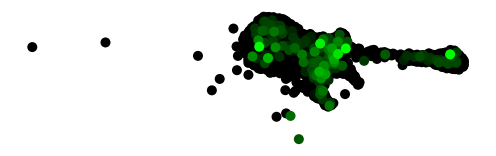

Cxcr3
17.978754364014318


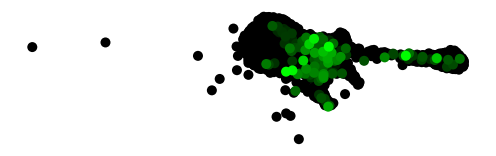

Smco4
27.88196316528321


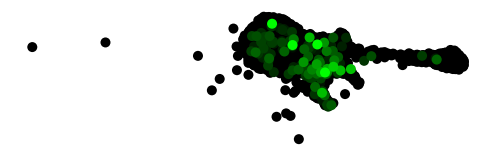

Ctla4
36.82735607910166


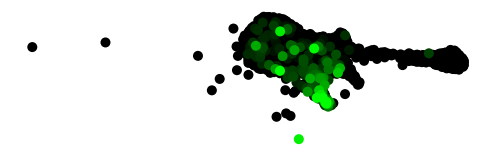

Smpdl3a
33.2477184143075


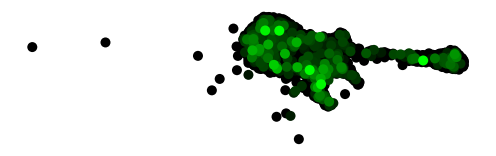

Nrp1
24.299448089602315


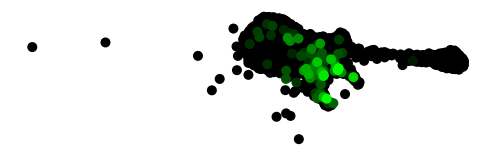

Itgae
27.542718948364403


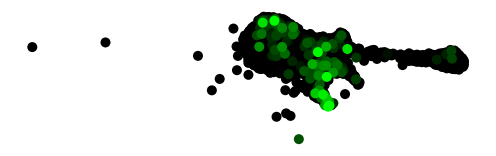

Maf
46.69515249633808


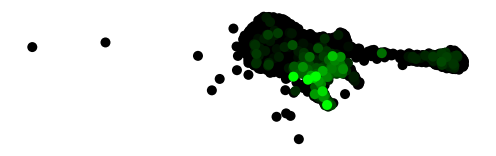

Glrx
28.914865814209364


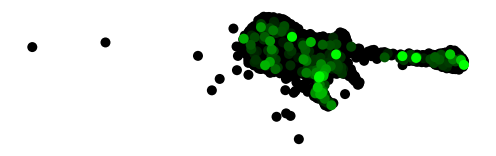

Trim59
28.667503799438567


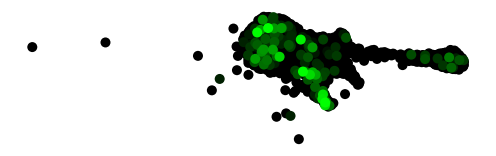

Izumo1r
34.29274725341831


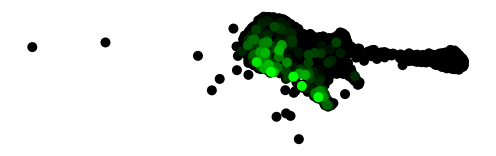

Ifi27l2a
27.477216644287978


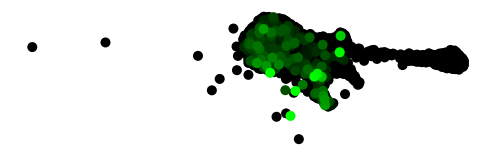

Mki67
20.72256936645512


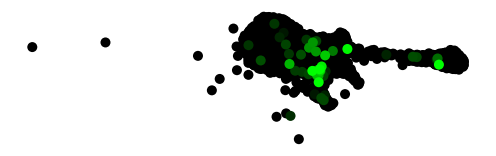

Tnfrsf4
27.896408889771536


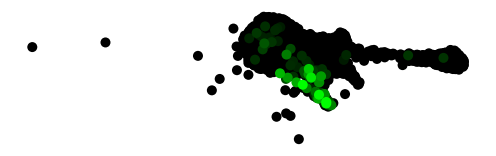

Foxp3
25.078818023681663


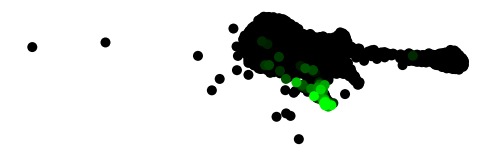

Hif1a
44.43422885131874


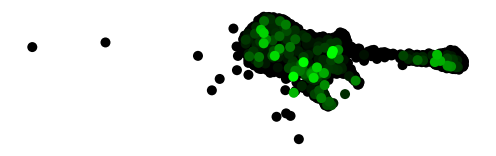

Arl5a
62.410163696289686


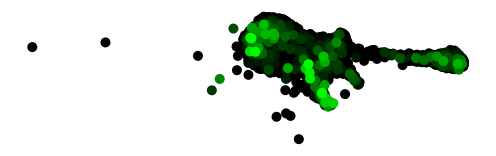

Cdk6
32.72387988281325


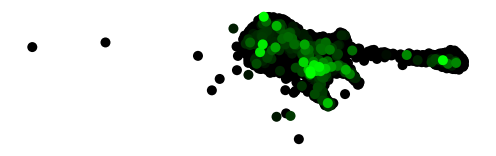

Tspan13
32.47476875305372


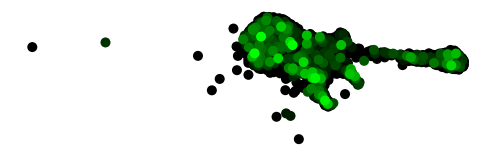

Jun
49.29892449951179


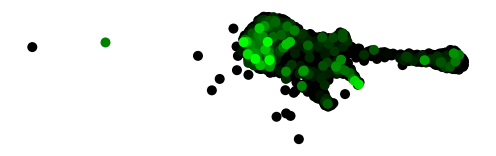

Nfkbiz
27.53091203308122


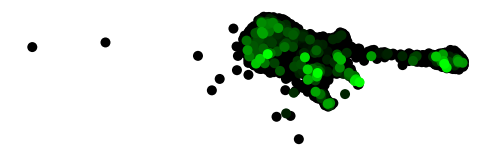

Nr4a1
35.13022726440476


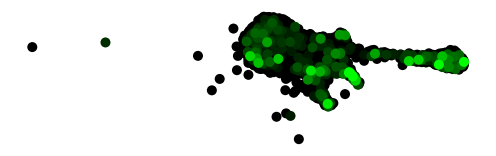

Il1rl1
26.306421737670952


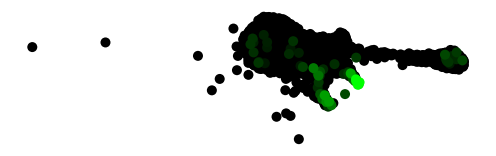

Areg
30.330267761230747


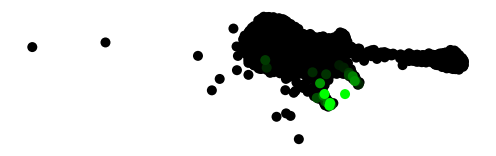

Cxcl2
41.61830300903367


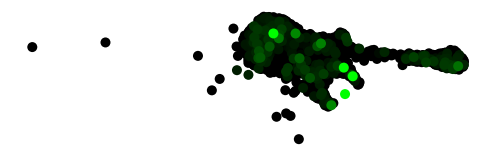

Ahcyl2
27.341052734375243


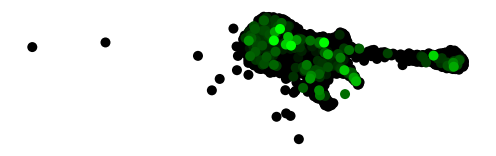

Hes1
23.828620803834042


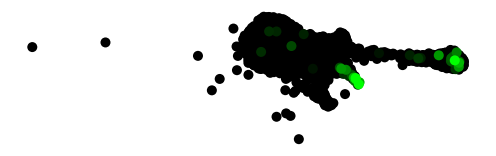

Kit
18.9947319793703


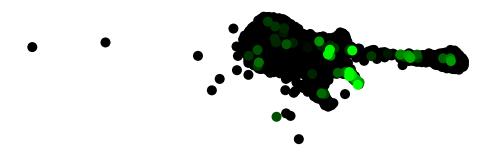

Arg1
14.416820877075455


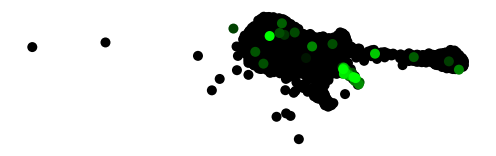

Slc7a8
12.88417253875756


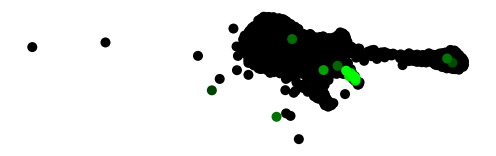

Prnp
23.5200839843751


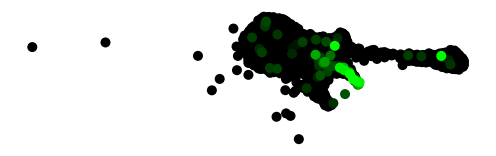

Pard3
14.76444092559826


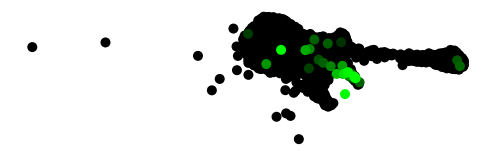

Rnf128
25.24520687866235


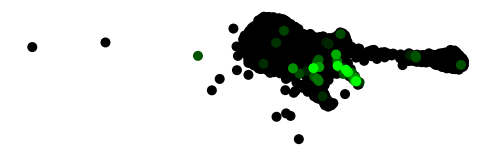

Hs3st1
16.75757148742715


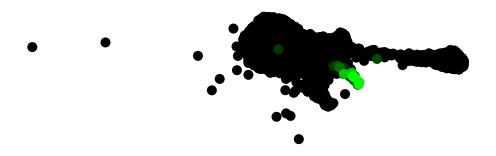

Calca
21.531322235107492


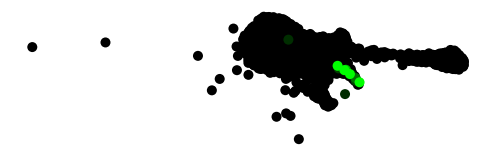

Fos
53.88283798217785


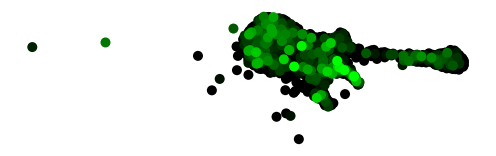

Egr1
48.12347857666038


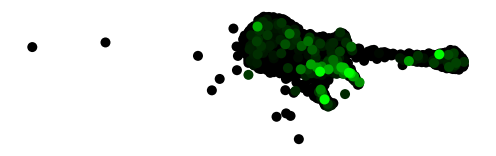

Gadd45b
23.804346481323545


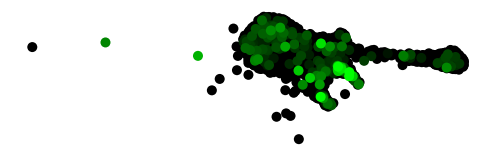

Junb
143.74145178222966


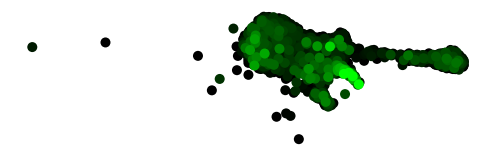

Cd81
25.644332000733193


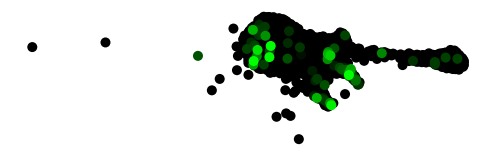

Cdkn1a
28.06094868469288


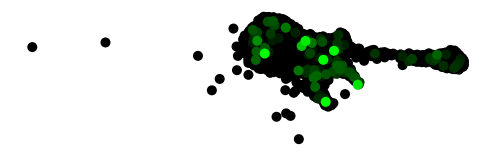

Irs2
29.48095472717453


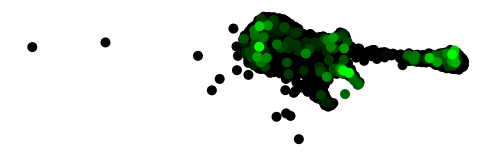

Gm42031
28.066424179078105


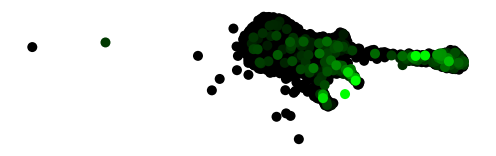

Ier2
44.484012359619584


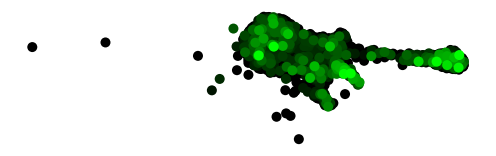

Fgl2
77.01391937256093


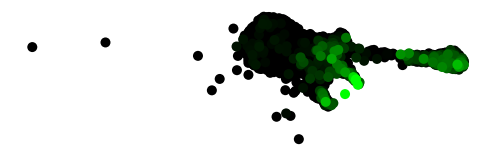

Ctla2a
88.57725726319009


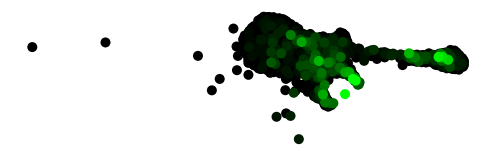

Crem
24.296164199829132


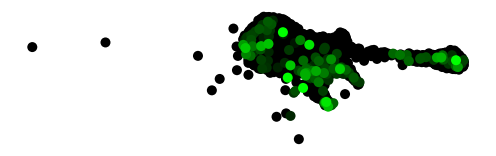

Dusp1
87.86432897949433


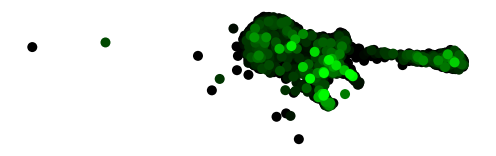

Srgn
105.523578735352


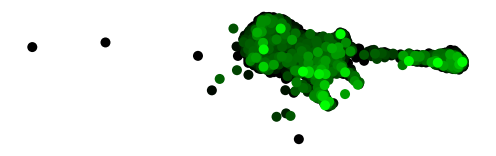

Cish
25.597434753418327


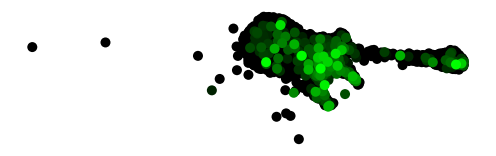

Cebpb
46.54446609497109


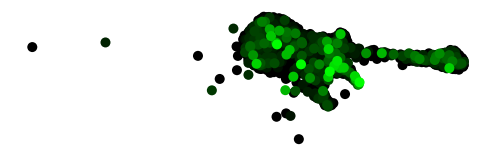

Mdfic
21.905248596191477


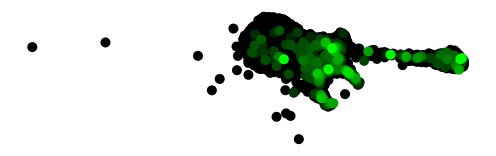

Il2ra
32.29841339111333


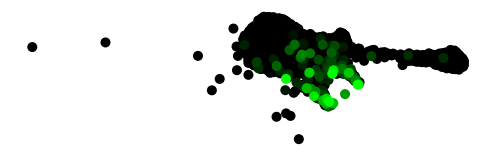

Zfp36l1
53.67939691162169


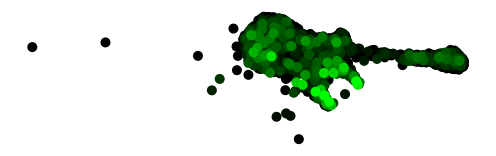

Rgs2
91.15882287597746


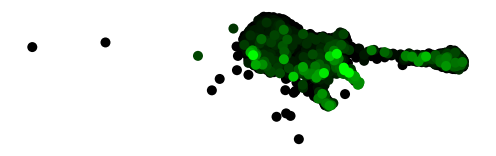

Gata3
62.71457070922871


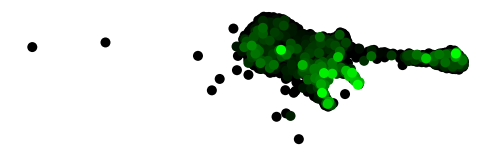

Itm2c
29.433944488526368


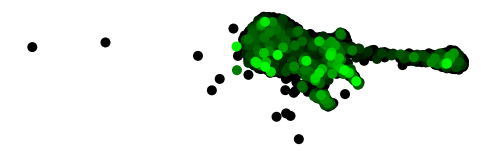

Tnfrsf18
37.19198416137714


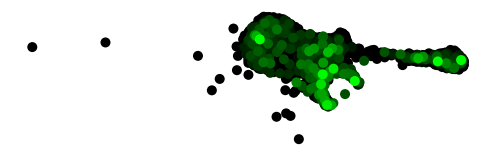

Ccr6
14.35883979034439


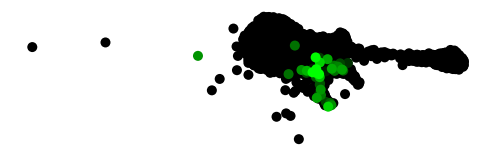

Blk
15.036318237304842


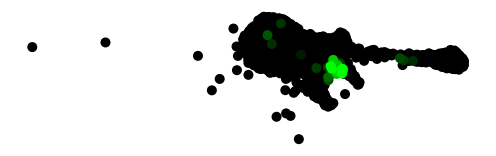

Cd163l1
17.792541748046943


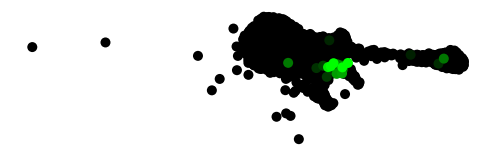

Il17re
14.768498123169634


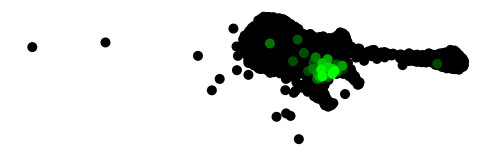

Tnf
24.602258926395656


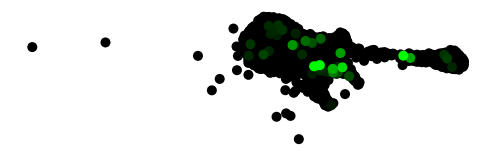

Sptssa
54.7041066894532


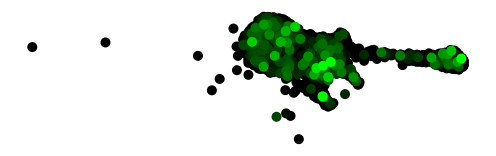

Aqp3
25.311764144899815


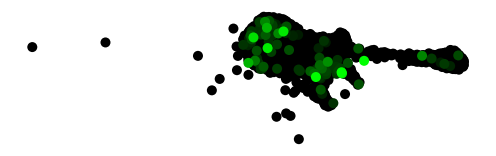

Lmo4
58.66214727783241


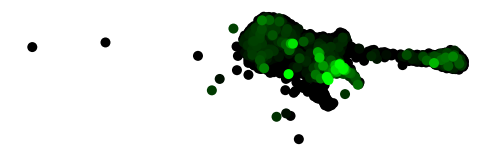

Ltb4r1
17.653588546753102


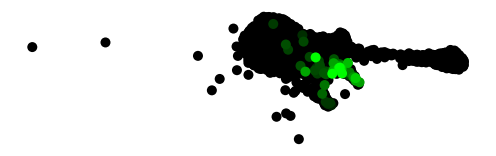

Ramp1
19.465038635253997


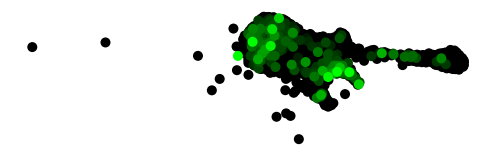

Tcrg-C1
27.741503952026434


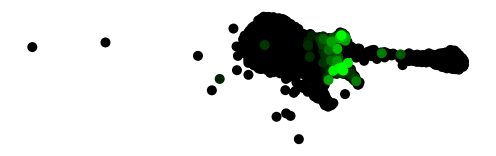

Krt83
25.07984806823778


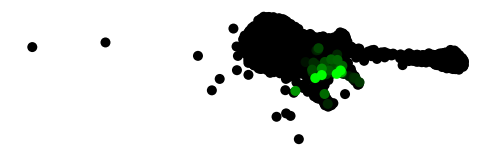

Tmem176a
28.16339418029792


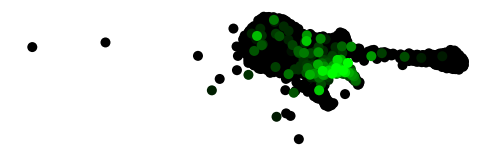

Tmem176b
38.27524688720708


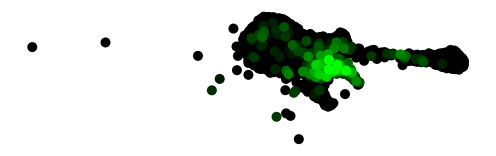

Igf1r
30.621823074341183


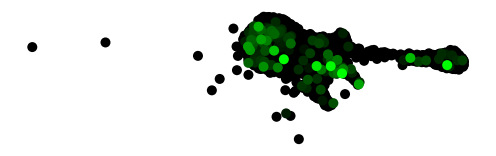

Rexo2
33.17275442504907


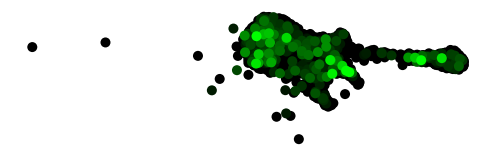

Serpinb1a
22.298391998291525


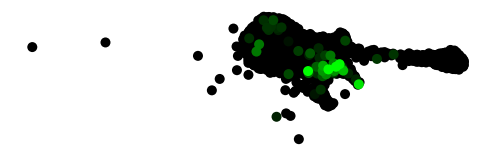

Smox
18.454703811645576


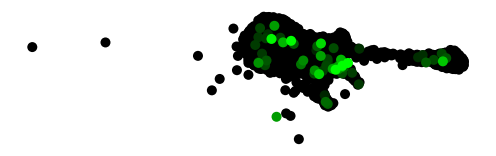

Tmem64
28.715872802736243


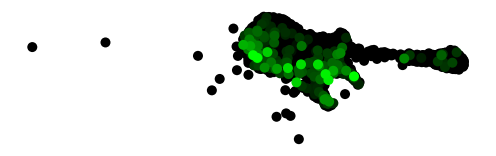

Icos
47.03985446167025


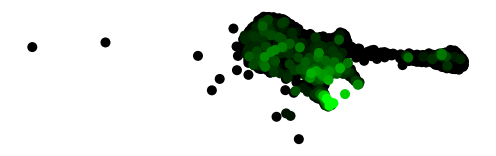

Ly6a
53.57608392334001


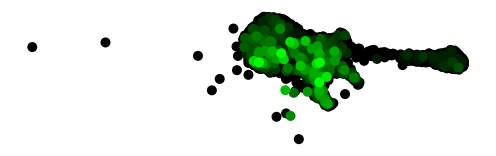

Rora
38.08770684814476


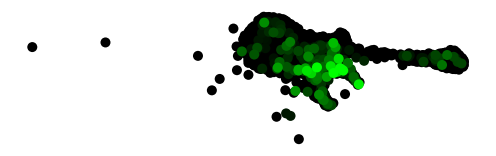

Capg
18.935042449951307


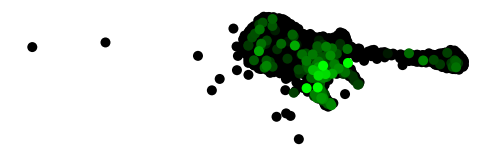

Bcl2a1b
23.130298614501953


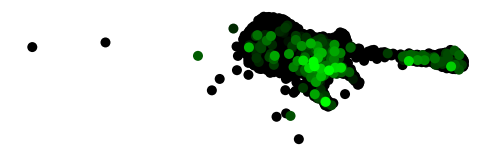

S100a4
48.99947326660173


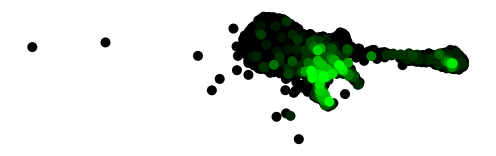

Cd82
36.54111303710961


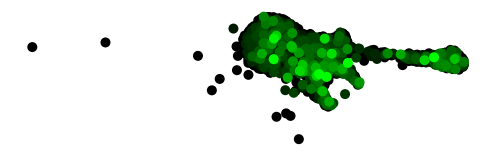

Ikzf2
51.22090069580108


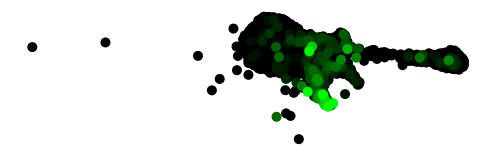

Odc1
48.603295043945344


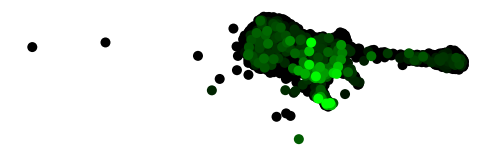

Cxcr6
49.72931588745195


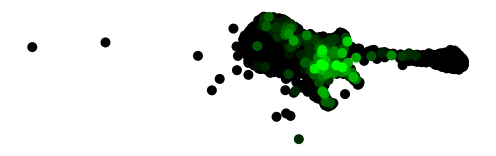

Socs2
33.65510809326197


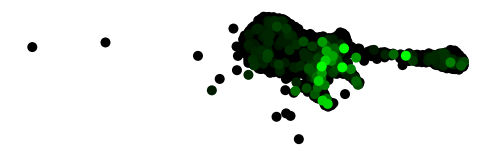

Tcrg-C4
42.71917382812564


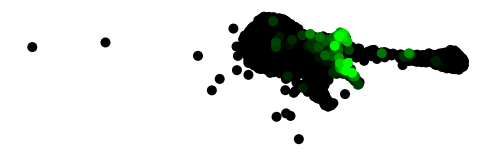

Tnfsf10
50.11684701538176


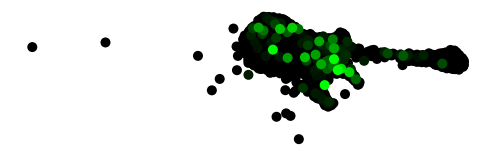

Lag3
8.08397858047505


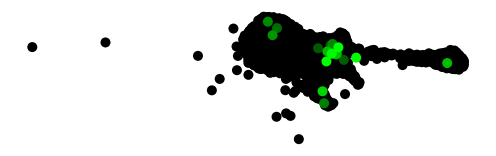

Pdcd1
16.71070790100112


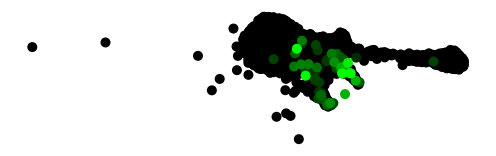

In [51]:
for gene in genes:
        
    print(gene)
    
    x1 = x[(cmask1)[cmask]]
    y1 = y[(cmask1)[cmask]]
    
    gmask = adata.var_names == gene
    expression = adata.X[cmask1][:,gmask].toarray().T[0]
    
    spring_like(
                gene,
                expression,
                x1,y1,
                box = [0,0,1,1],
                pctilemax=pctilemax,
                s = 100,
                w = 17,
                h = 5,
                comment = 'TNK_all_cond_',
                pad = 0,
                ftype = 'png',
                dpi = 600.,
                show_cbar=False,
                lims = [xlims[0],ylims[0],xlims[1],ylims[1]],
                save=True,
                show=True,
                outputdir='outputs/tnkcells/'
                )



### Same plot but for each condition separately

CSF1Ri


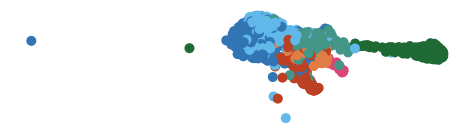

Vehicle


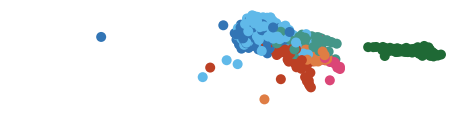

Healthy


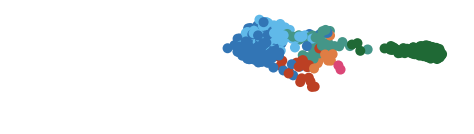

In [56]:
for cond in adata.obs.dropna()['condition'].unique():
    
    print(cond)
    cmask2 = adata.obs['condition'] == cond
    cmask2 = cmask2.values
    
    x1 = x[(cmask1&cmask2)[cmask]]
    y1 = y[(cmask1&cmask2)[cmask]]
    
    colors = [cdd[colorby][i] for i in adata.obs[colorby][cmask1&cmask2]]
    
    # plot
    a,fig,gs = rz.startfig(17,5,frameon=False)
    a.scatter(x1,y1,color=colors,lw=0,s=100)
    
    a.set_xticks([])
    a.set_yticks([])
    
    # prevent plot for being recentered relatively to the "all conditions" one
    a.set_xlim(xlims[0],xlims[1])
    a.set_ylim(ylims[0],ylims[1])
    
    gs.tight_layout(fig)
    
    plt.savefig('outputs/tnkcells/tnk_%s.png'%cond,dpi=600)
    plt.savefig('outputs/tnkcells/tnk_%s.pdf'%cond)
    plt.show()
    

### Expression of Ifng in each condition separately

In [57]:
# genes to plot
genes = ['Ifng']
pctilemax = 99.9

In [58]:
# First, I want to find the value to saturate the color at.
# I chose to saturated at the x-th percentile across all CD45 cells including all conditions

pctiledict = {}

for gene in genes:
    gmask = adata.var_names == gene
    expression = adata.X[cmask][:,gmask].toarray().T[0]
    pctiledict[gene] = np.percentile(expression,pctilemax)

CSF1Ri Ifng
19.43401560592908


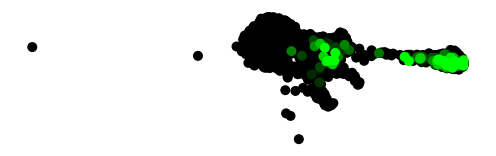

Vehicle Ifng
19.43401560592908


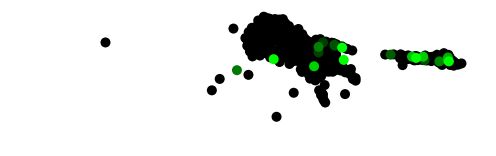

Healthy Ifng
19.43401560592908


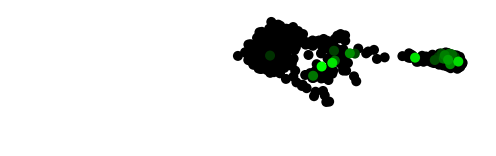

In [59]:
for gene in genes:
    for cond in adata.obs.dropna()['condition'].unique():
        
        print(cond,gene)
        cmask2 = adata.obs['condition'] == cond
        cmask2 = cmask2.values
        
        x1 = x[(cmask1&cmask2)[cmask]]
        y1 = y[(cmask1&cmask2)[cmask]]
        
        gmask = adata.var_names == gene
        expression = adata.X[cmask1&cmask2][:,gmask].toarray().T[0]
        
        spring_like(
                    gene,
                    expression,
                    x1,y1,
                    box = [0,0,1,1],
                    s = 100,
                    vmax=pctiledict[gene],
                    w = 17,
                    h = 5,
                    comment = 'split_by_%s'%cond,
                    pad = 0,
                    ftype = 'png',
                    dpi = 600.,
                    show_cbar=False,
                    lims = [xlims[0],ylims[0],xlims[1],ylims[1]],
                    save=True,
                    show=True,
                    outputdir='outputs/tnkcells/'
                    )
    